Kaggle competition on predicting house prices from the Ames data set:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/details

Analysis conducted:
- Data cleaning and visualization
- Residual analysis for Ordinary Least Squares

Methods used:
- Ordinary least squares (Unregularized linear regression)
- Ridge regression
- LASSO regression for feature selection

Methods to explore in future:
- Same linear models, but with some prior feature selection
- Generalized low rank models (eg PCA)

Note:
- Description of features (provided by organizer) has been provided in `More data descriptions.doc` in the `Data` folder 
- Partial credits for data processing and linear models go to: Alexandru Papiu and juliencs.
- Feedback are most welcome! Thank you.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
sb.set_style("whitegrid")

import matplotlib.pyplot as plt
import scipy.stats as stats


from pandas import DataFrame
from scipy.stats import skew, probplot
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
import os
cwd = os.getcwd()
path = os.path.join(cwd, 'Data')
train = pd.read_csv(os.path.join(path, 'train.csv'))
test = pd.read_csv(os.path.join(path, 'test.csv'))

In [3]:
train.head()
test.head()
print ("Dimensions of train.csv:", train.shape)
print ("Dimensions of test.csv:", test.shape)

Dimensions of train.csv: (1460, 81)
Dimensions of test.csv: (1459, 80)


In [4]:
# combine all rows from train.csv and test.csv
all_data=pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']],ignore_index=True)
print ("Dimensions of all data:", all_data.shape)
all_data.head()

Dimensions of all data: (2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# Data Processing


Data preprocessing: 

- Convert certain numeric variables to categorical as they are actually categorical
- Encode ordinal categoricals into numbers
- Transform the POSITIVELY skewed numeric features by taking log(feature)
- Create dummy variables for the categorical features    
- Remove outliers
- Split the data into training set, validation set and test set
- Replace the numeric missing values (NaN's) with the mean of their respective columns. Note: To prevent data snooping, the column means for the training set, validation set and test set are calculated separately.

In [5]:
# some numeric values are actually categorical. convert these to dummies.
all_data = all_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

# some "NAs" don't mean 'missing'. convert them to something more meaningful
all_data.loc[:, "Alley"] = all_data.loc[:, "Alley"].fillna("None")
all_data.loc[:, "BsmtQual"] = all_data.loc[:, "BsmtQual"].fillna("None")
all_data.loc[:, "BsmtCond"] = all_data.loc[:, "BsmtCond"].fillna("None")
all_data.loc[:, "BsmtExposure"] = all_data.loc[:, "BsmtExposure"].fillna("None")
all_data.loc[:, "BsmtFinType1"] = all_data.loc[:, "BsmtFinType1"].fillna("None")
all_data.loc[:, "BsmtFinType2"] = all_data.loc[:, "BsmtFinType2"].fillna("None")
all_data.loc[:, "FireplaceQu"] = all_data.loc[:, "FireplaceQu"].fillna("None")
all_data.loc[:, "GarageType"] = all_data.loc[:, "GarageType"].fillna("None") 
all_data.loc[:, "GarageFinish"] = all_data.loc[:, "GarageFinish"].fillna("None") 
all_data.loc[:, "GarageQual"] = all_data.loc[:, "GarageQual"].fillna("None")
all_data.loc[:,'GarageCond']= all_data.loc[:, "GarageCond"].fillna("None")
all_data.loc[:,'PoolQC']= all_data.loc[:, "PoolQC"].fillna("None")
all_data.loc[:,'Fence']= all_data.loc[:, "Fence"].fillna("None")
all_data.loc[:, "MiscFeature"] = all_data.loc[:, "MiscFeature"].fillna("None")

# encode ordinal categoricals into numbers

ordinals = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
            'ExterCond', 'ExterQual', 'FireplaceQu', 'Functional', 'GarageCond', 'GarageQual',
           'HeatingQC', 'KitchenQual','LandSlope', 'LotShape', 'PavedDrive', 'PoolQC', 'Street',
            'Utilites']
all_data = all_data.replace({"Alley" : {"None": 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"None" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"None" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Fence": {"None": 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv":4},      
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B44A587B8>]], dtype=object)

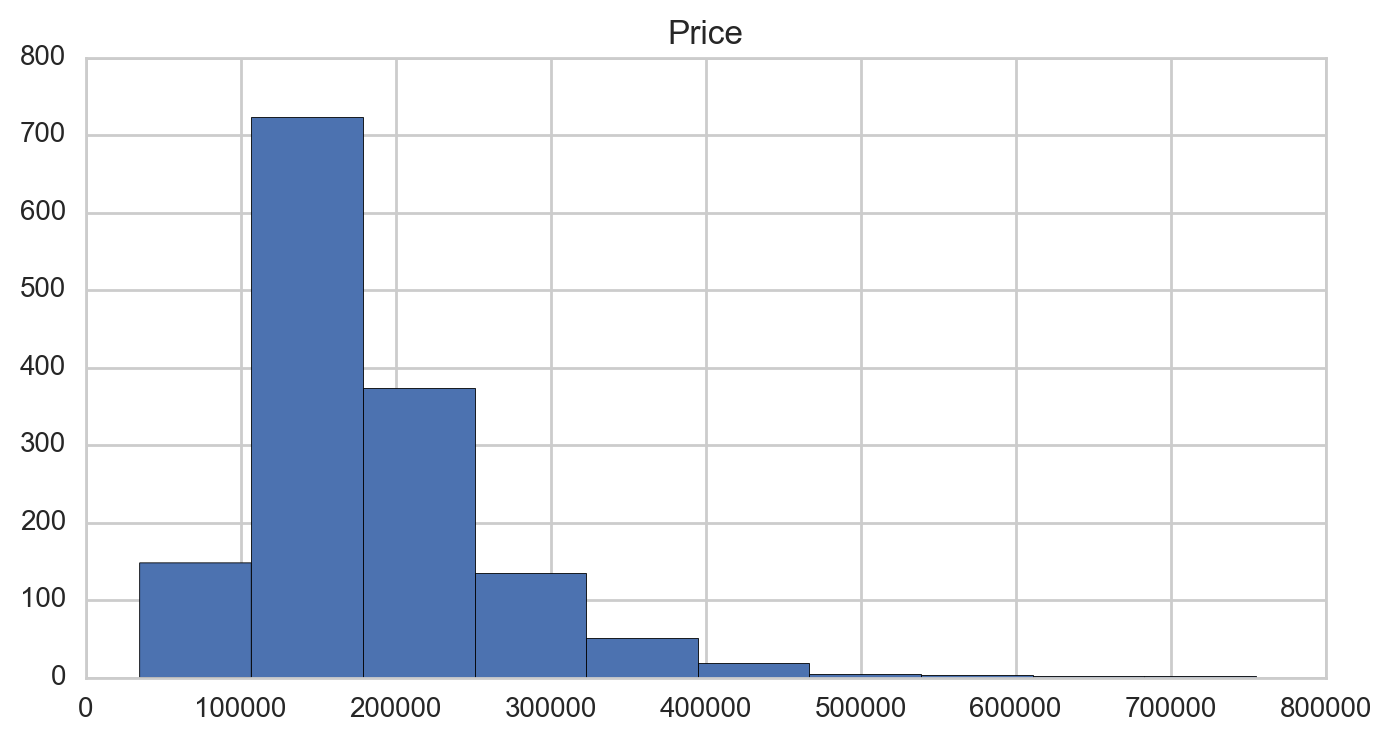

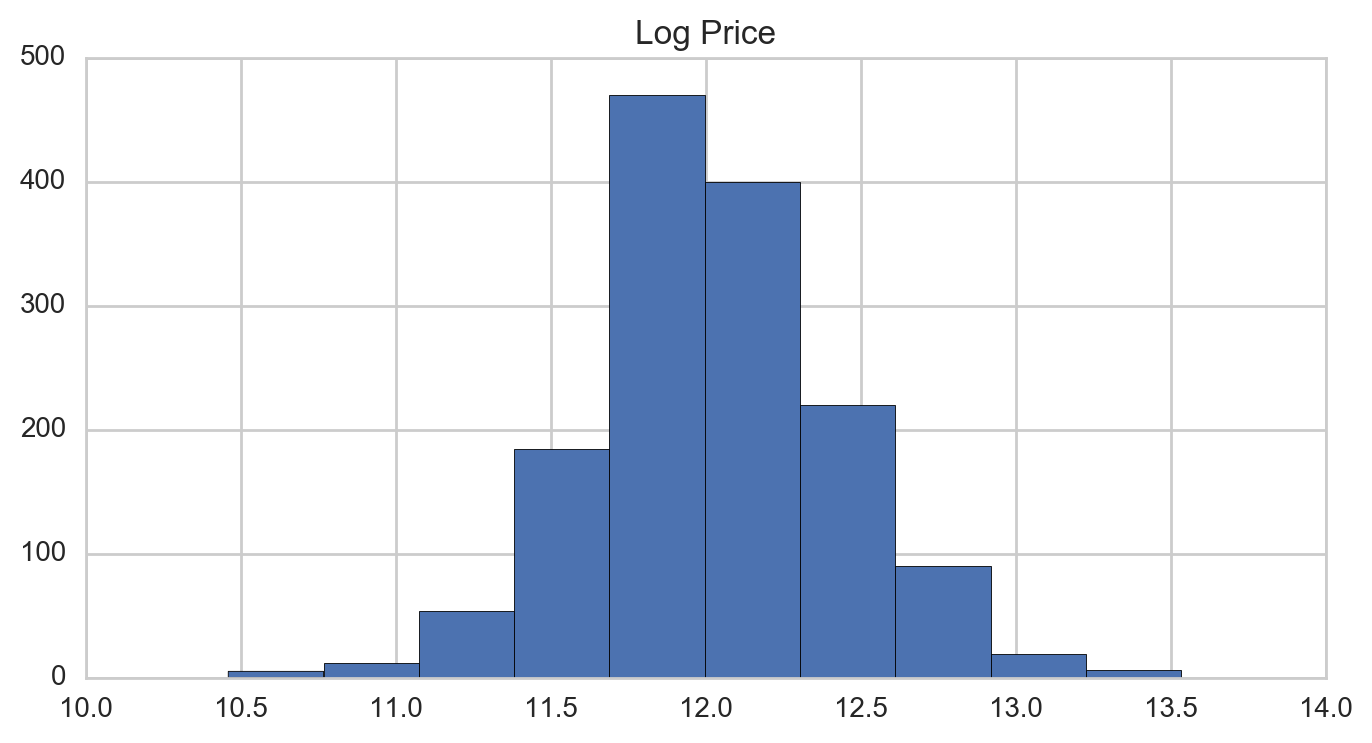

In [6]:
# From graphs, observe that price is positively skewed
mp.rcParams['figure.figsize'] = (8, 4.0)
price = pd.DataFrame({"Price":train["SalePrice"]})
price.hist()

train['LogPrice'] = np.log1p(train['SalePrice']) # add new column to dataset
logprice = pd.DataFrame({"Log Price":train['LogPrice']})
logprice.hist()


In [7]:
# calculate skewness of numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

# log transform features with high skewness
skewed_feats = skewed_feats[skewed_feats > 0.75 ]
skewed_feats = skewed_feats.index # stores the column names
all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) 

# convert categorical data to dummy variables
all_data = pd.get_dummies(all_data)
print ("New dimensions of all data with dummy variables:", all_data.shape)


New dimensions of all data with dummy variables: (2919, 259)


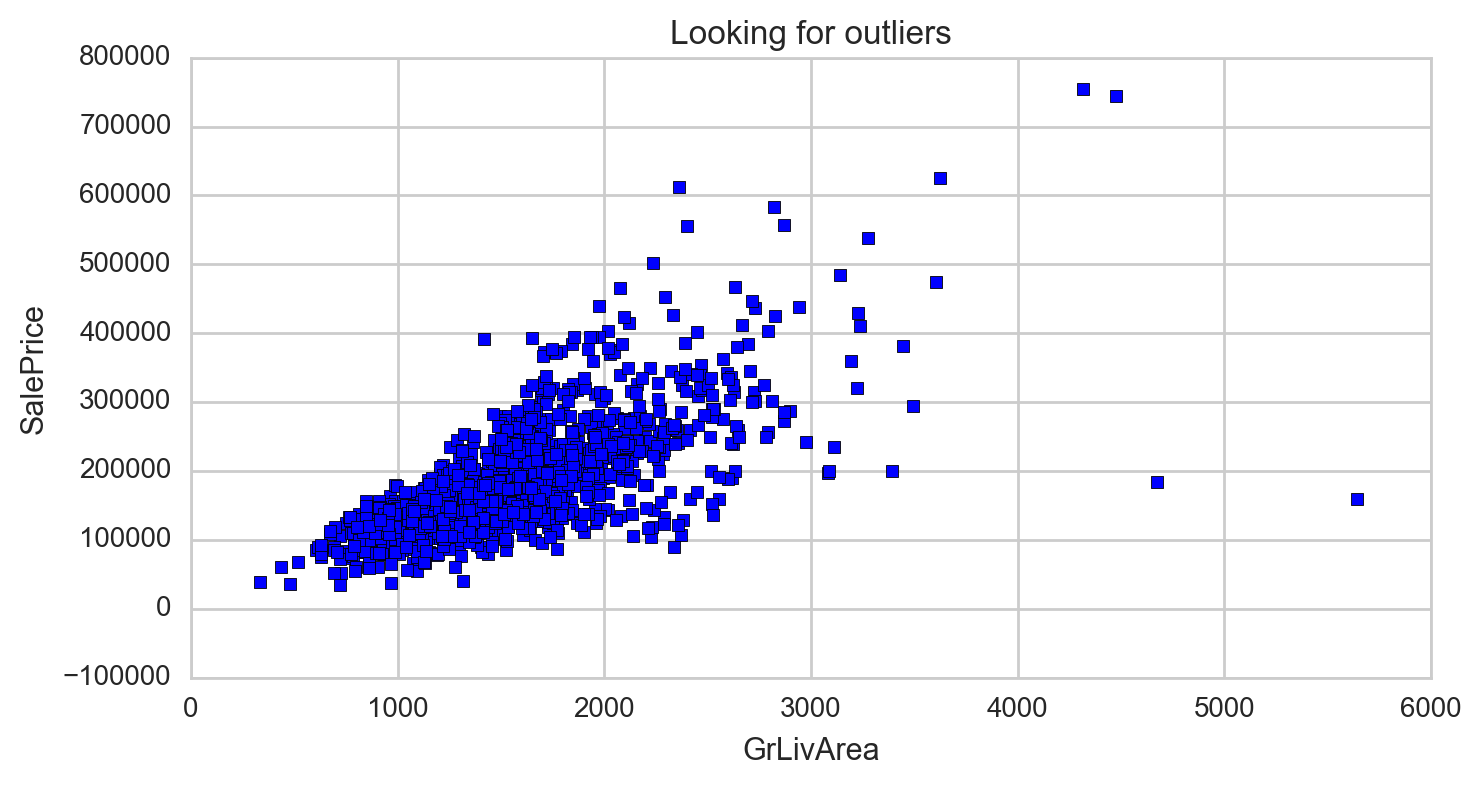

Indices of outliers: (array([ 523,  691, 1182, 1298], dtype=int64),)
Dimensions of all data: (2919, 259)
Updated dimensions in combined dataset: (2915, 259)
Updated dimensions in training set: (1456, 82)


In [8]:
# looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.clf()

mp.rcParams['figure.figsize'] = (5, 5.0)
plt.clf()
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()


# remove outliers
outliers = np.where(train.GrLivArea > 4000)
print ("Indices of outliers:",outliers)
print ("Dimensions of all data:", all_data.shape)

all_data= all_data.drop(all_data.index[outliers])
train = train.drop(train.index[outliers])

print ("Updated dimensions in combined dataset:", all_data.shape)
print ("Updated dimensions in training set:", train.shape)


In [9]:
# create X and y matrices for training, validation and test sets
# note: there is no y_test as we're supposed to predict unlabelled data

from sklearn.cross_validation import train_test_split


X_temp = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

y_temp = train['LogPrice']

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print ("Dimensions of X_train:", X_train.shape)
print ("Dimensions of y_train:", y_train.shape)
print ("Dimensions of X_val:", X_val.shape)
print ("Dimensions of y_val:", y_val.shape)
print ("Dimensions of X_test:", X_test.shape)



Dimensions of X_train: (1092, 259)
Dimensions of y_train: (1092,)
Dimensions of X_val: (364, 259)
Dimensions of y_val: (364,)
Dimensions of X_test: (1459, 259)


In [10]:
# replace NAs with column means
# column means are calculated AFTER removing outliers
# to prevent data snooping, means are calculated separately for training, validation and test sets

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats
X_train.loc[:, numeric_feats] = X_train.loc[:,numeric_feats].fillna(X_train.mean())
X_val.loc[:, numeric_feats] = X_val.loc[:,numeric_feats].fillna(X_val.mean())
X_test.loc[:, numeric_feats]=X_test.loc[:,numeric_feats].fillna(X_test.mean())

C:\Users\User\AppData\Local\Anaconda\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [11]:
# verify that there is no missing data
print ("Any NaNs present in X_train?", np.all(np.isnan(X_train)))
print ("Any NaNs present in X_val?", np.all(np.isnan(X_val)))
print ("Any NaNs present in X_test?", np.all(np.isnan(X_test)))
print ()
print ("Any NaNs present in y_train?", np.all(np.isnan(y_train)))
print ("Any NaNs present in y_val?", np.all(np.isnan(y_val)))

Any NaNs present in X_train? False
Any NaNs present in X_val? False
Any NaNs present in X_test? False

Any NaNs present in y_train? False
Any NaNs present in y_val? False


# Data Visualization

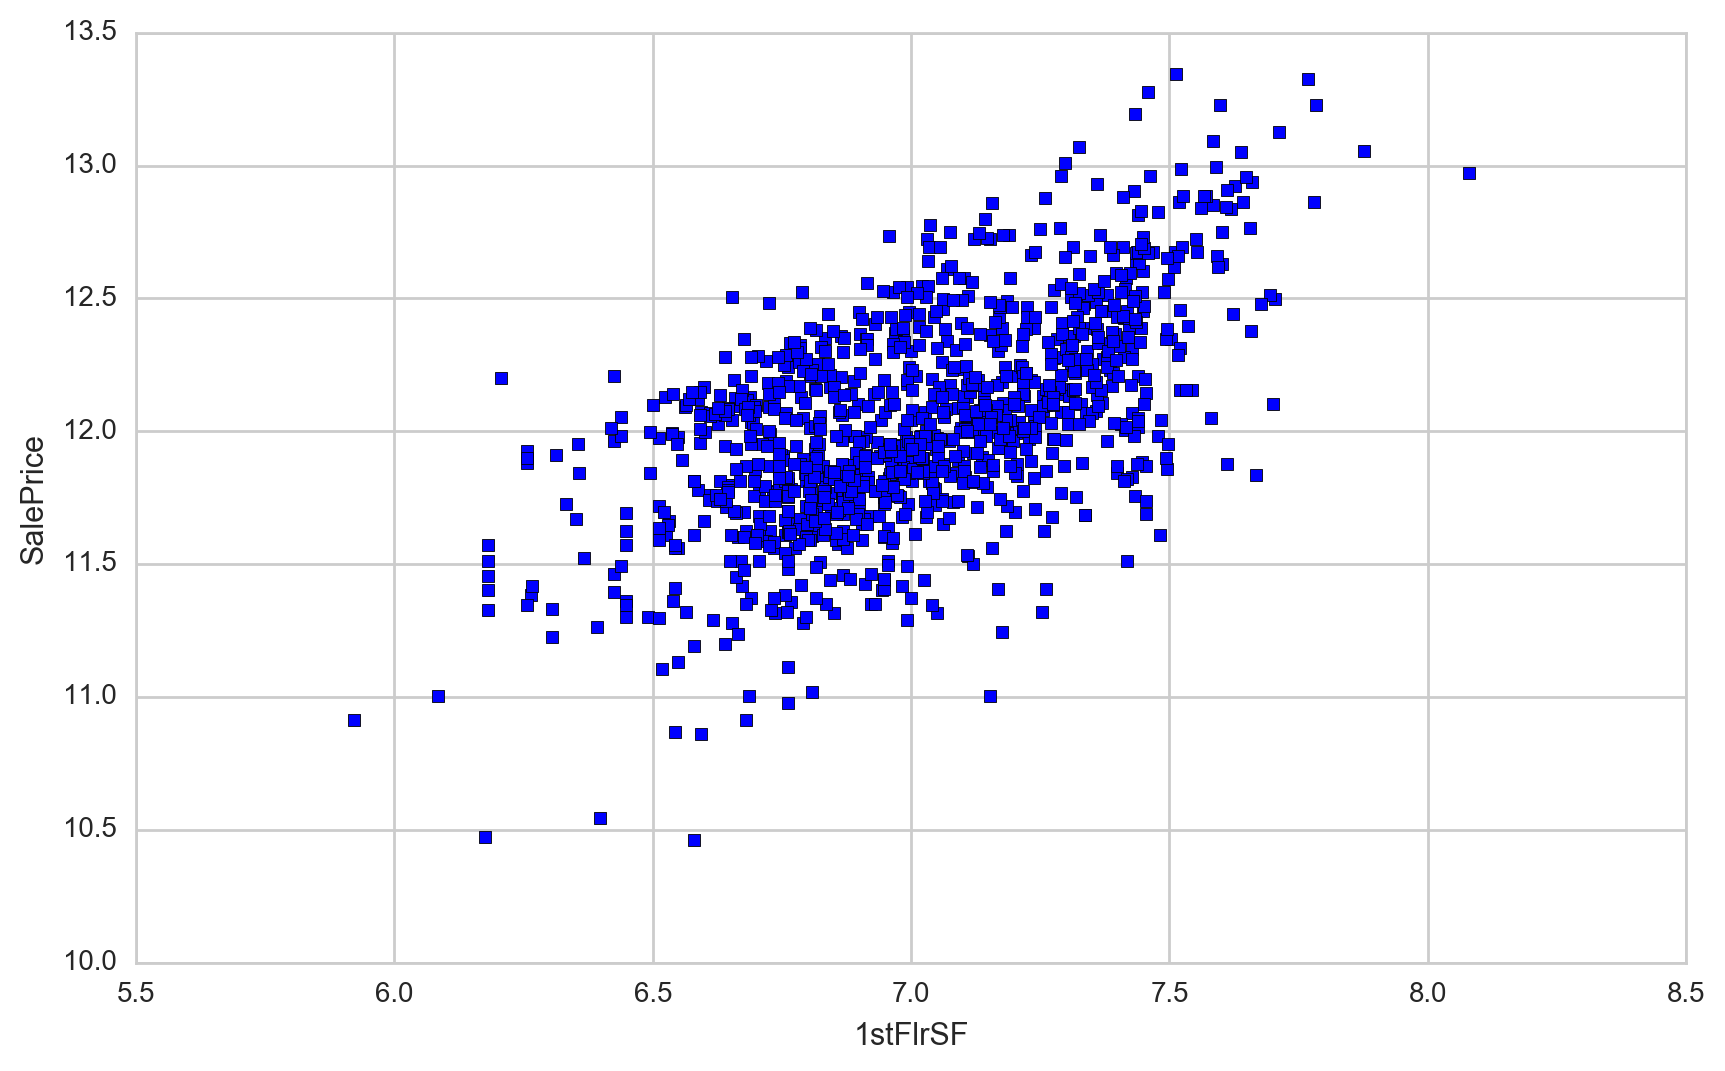

In [12]:
# plotting price against 1stFlrSF
mp.rcParams['figure.figsize'] = (10.0, 6.0)

plt.scatter(X_train['1stFlrSF'], y_train, c = "blue", marker = "s")
plt.xlabel("1stFlrSF")
plt.ylabel("SalePrice")
plt.show()

From the box plots, we can see that there is a ordinal relationship between these categorical values and the sales price. This is why they were converted to ordinal numbers earlier in the data processing section.

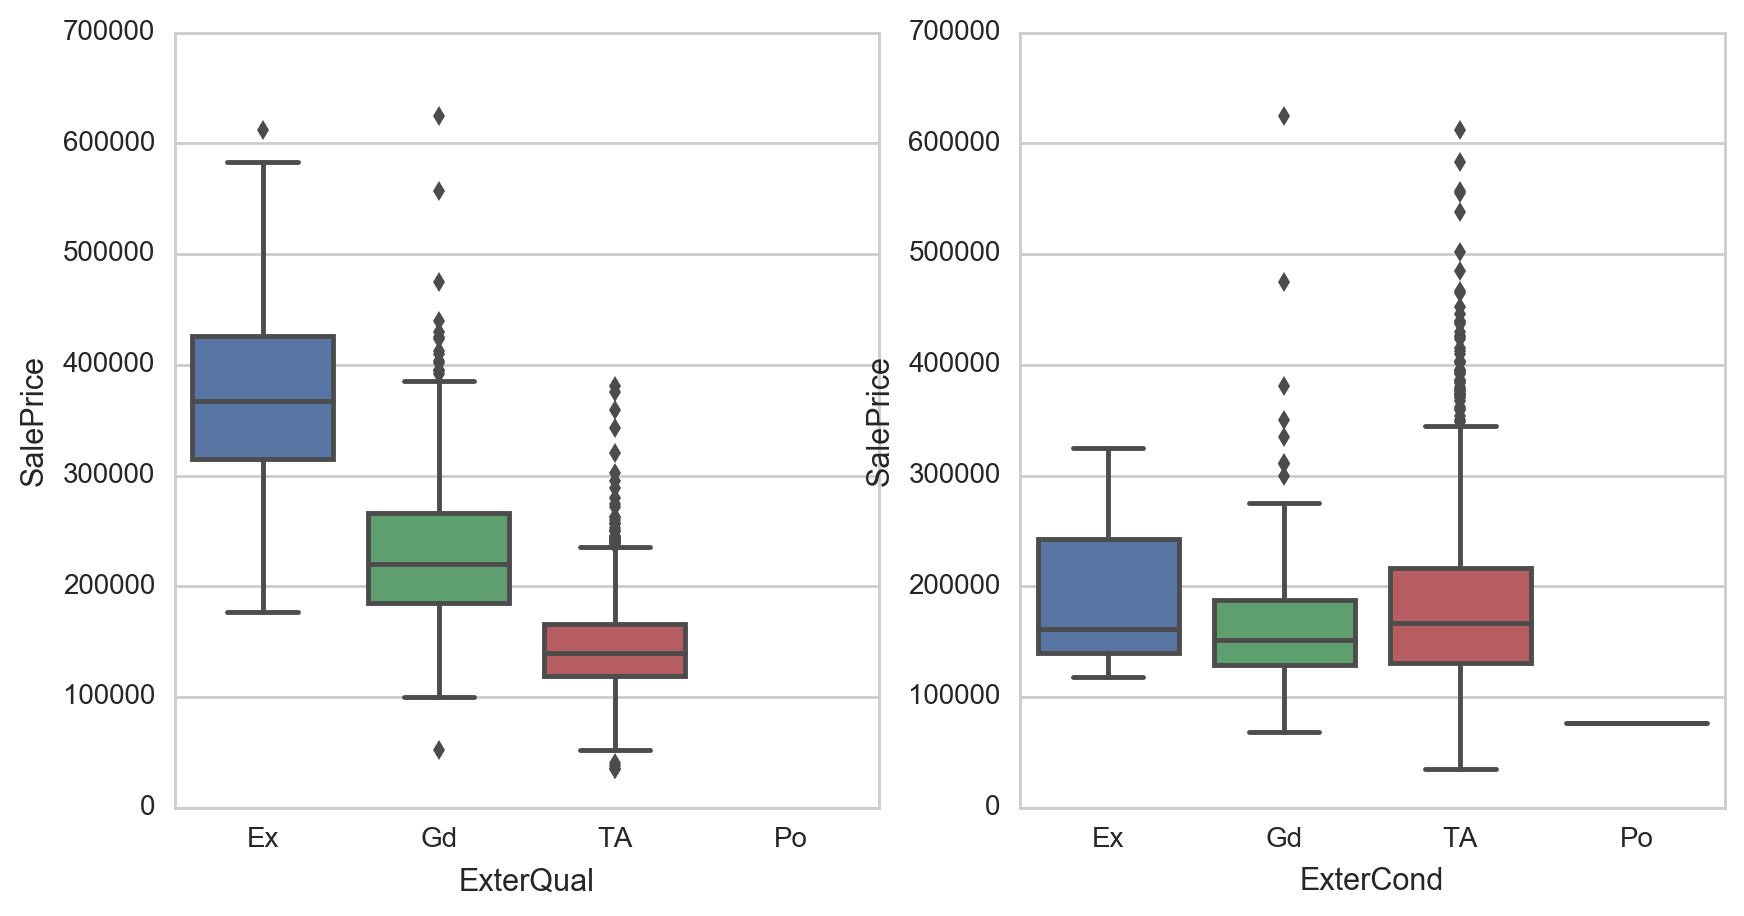

In [13]:
# from best to worst: excellent, good, typical/average (TA), poor
mp.rcParams['figure.figsize'] = (10, 5.0)

plt.subplot(121)
sb.boxplot(x=train.ExterQual, y = train.SalePrice, order = ['Ex', 'Gd', 'TA', 'Po'])

plt.subplot(122)
sb.boxplot(x=train.ExterCond, y=train.SalePrice, order = ['Ex', 'Gd', 'TA', 'Po'])




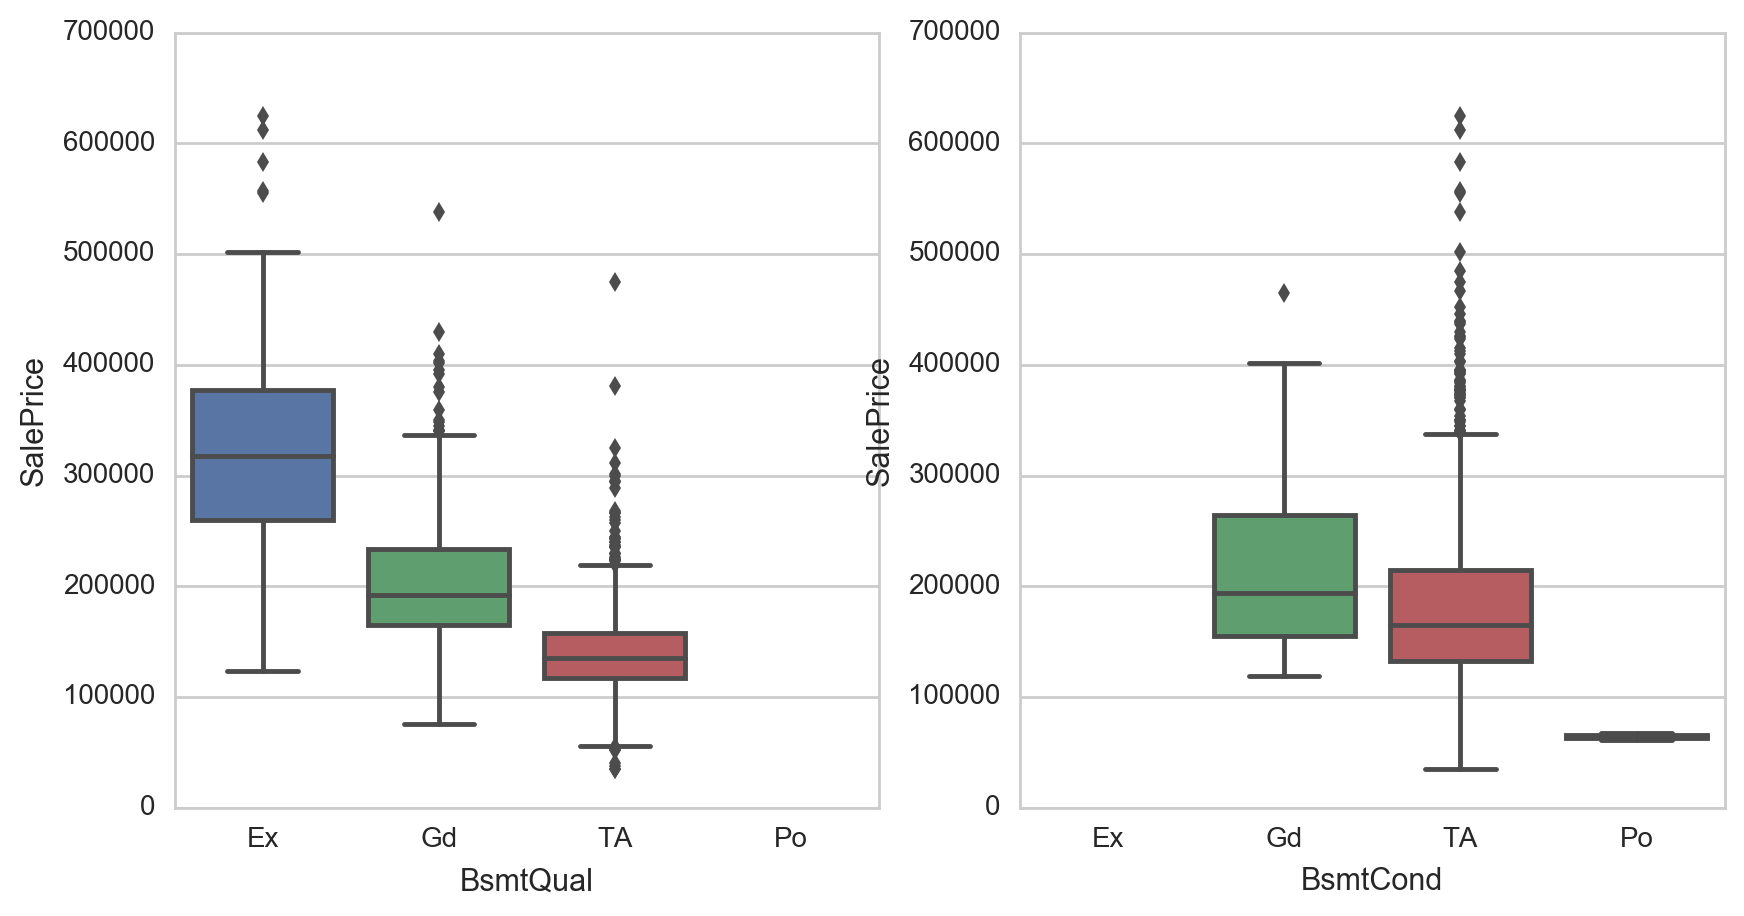

In [14]:
mp.rcParams['figure.figsize'] = (10, 5.0)
plt.subplot(121)
sb.boxplot(x=train.BsmtQual, y=train.SalePrice, order = ['Ex', 'Gd', 'TA', 'Po'])
plt.subplot(122)
sb.boxplot(x=train.BsmtCond, y=train.SalePrice, order = ['Ex', 'Gd', 'TA', 'Po'])


A: Agriculture
C: Commercial
FV: Floating Village Residential
I: Industrial
RH: Residential High Density
RL: Residential Low Density
RP: Residential Low Density Park
RM: Residential Medium Density


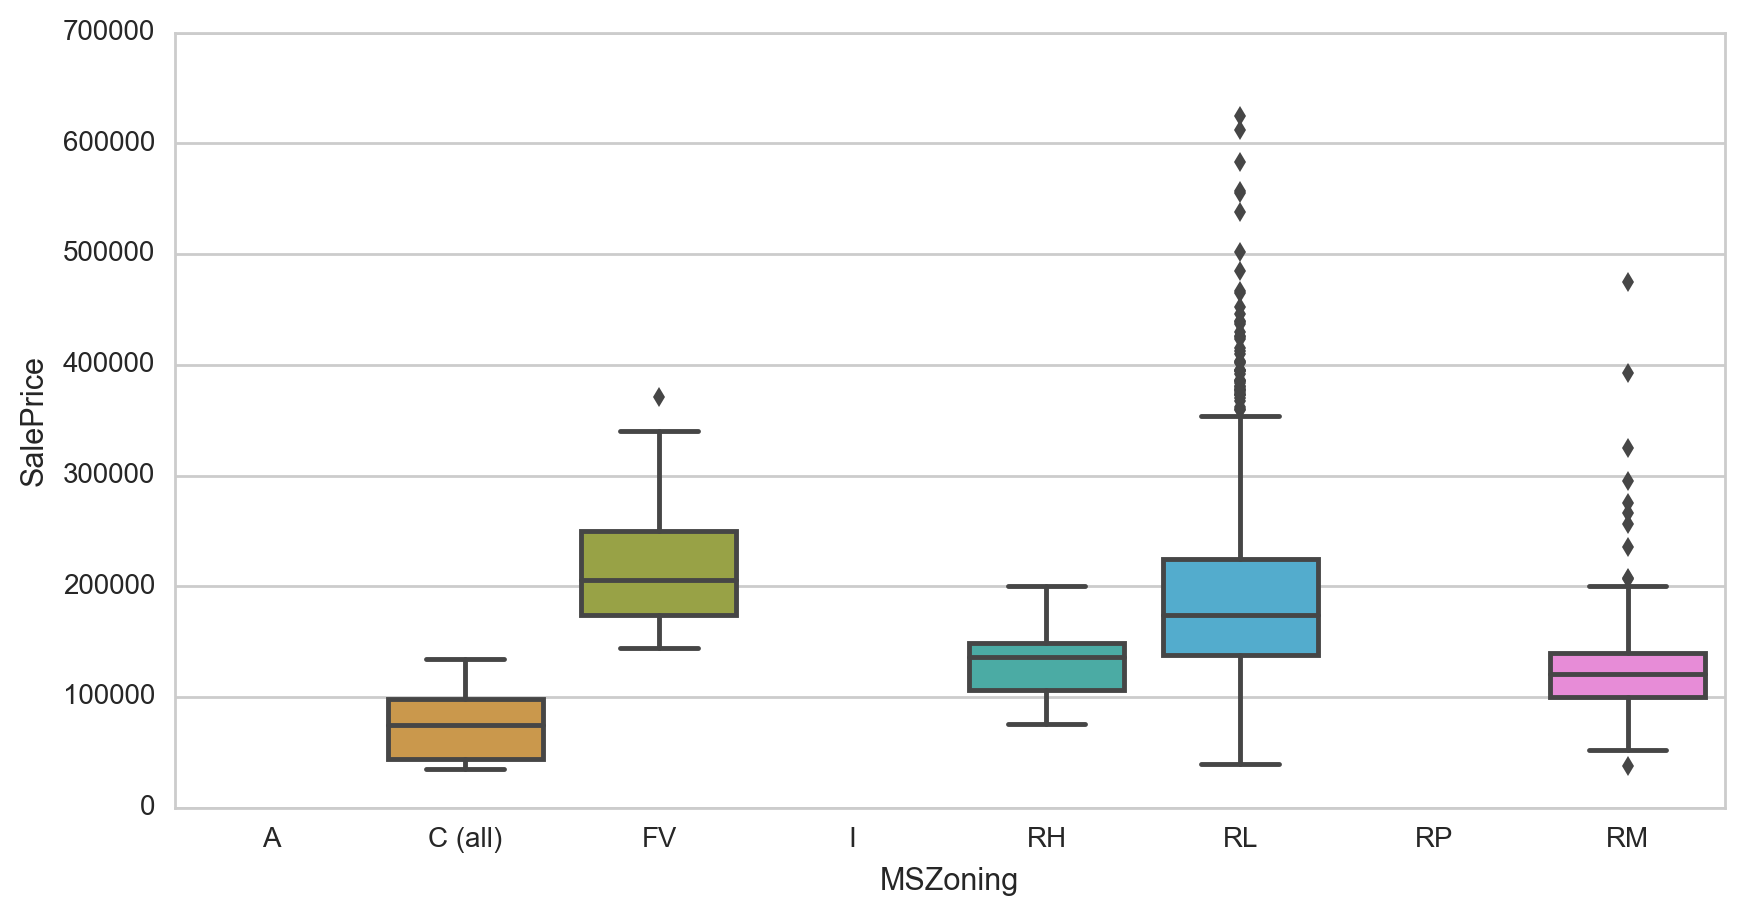

In [15]:
sb.boxplot(x=train.MSZoning, y=train.SalePrice, order = ['A', 'C (all)', 'FV','I','RH', 'RL', 'RP', 'RM'])

print ("A: Agriculture")
print ("C: Commercial")
print ("FV: Floating Village Residential")
print ("I: Industrial")
print ("RH: Residential High Density")
print ("RL: Residential Low Density")
print ("RP: Residential Low Density Park")
print ("RM: Residential Medium Density")



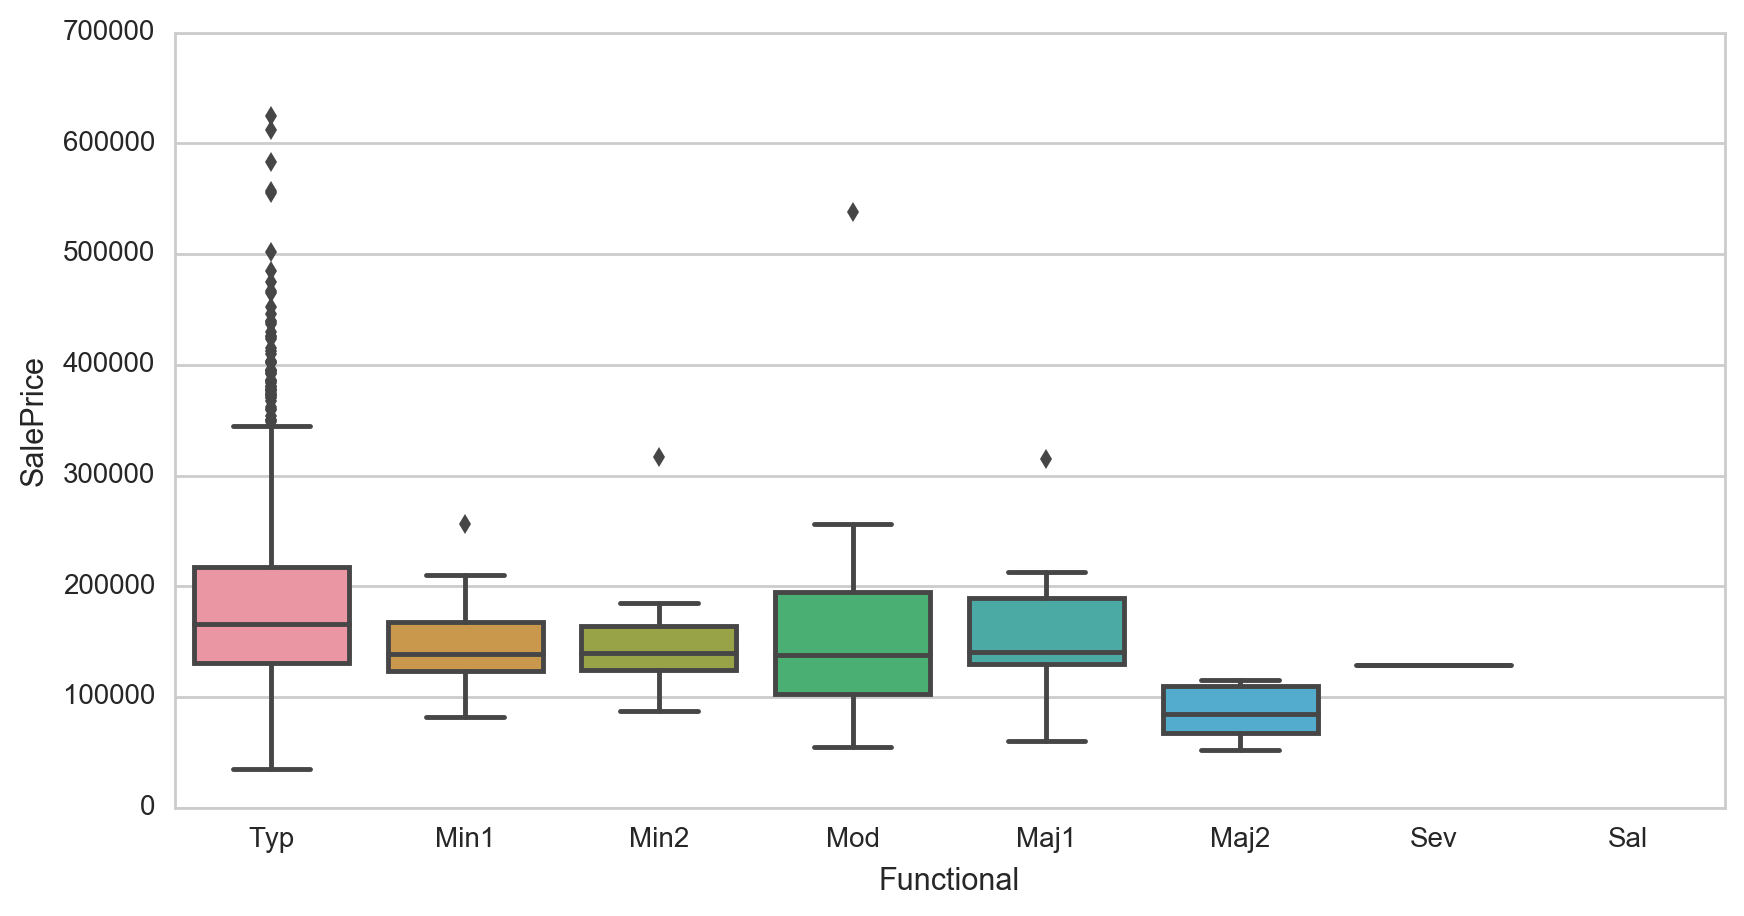

In [16]:
sb.boxplot(x=train.Functional, y=train.SalePrice, order = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'])

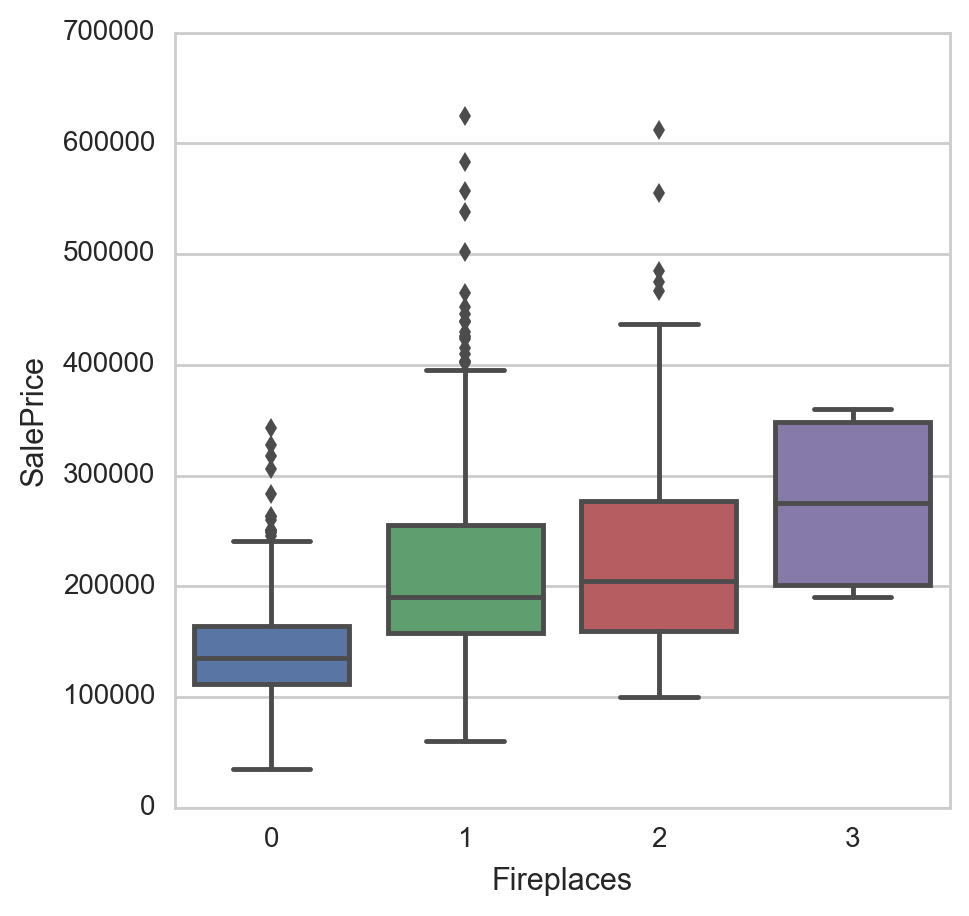

In [17]:
mp.rcParams['figure.figsize'] = (5, 5.0)
sb.boxplot(x=train.Fireplaces, y=train.SalePrice)

Top five neighborhoods from highest to lowest price: Index(['NridgHt', 'NoRidge', 'StoneBr', 'Timber', 'Somerst'], dtype='object', name='Neighborhood')
Bottom five neighborhoods from lowest to highest price: Index(['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards'], dtype='object', name='Neighborhood')


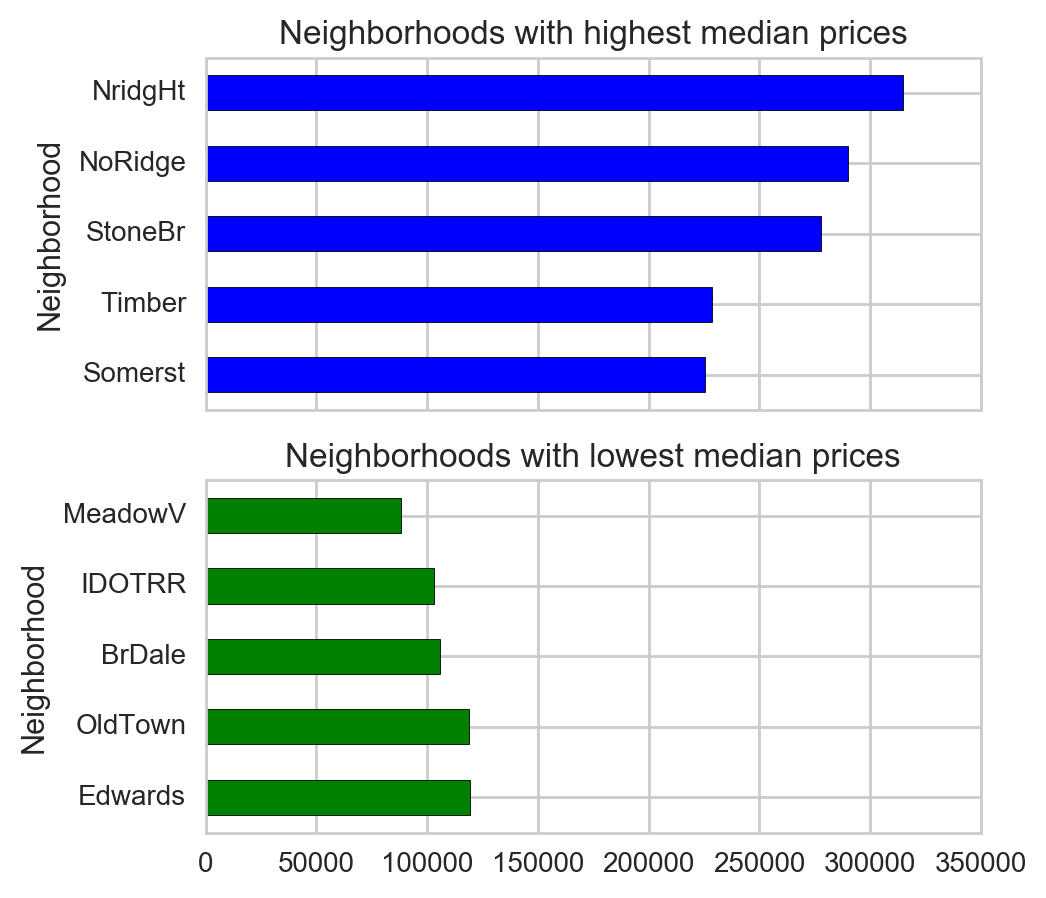

In [18]:
# sort neighborhoods by median sales price
grouped = train['SalePrice'].groupby(train["Neighborhood"]).median()
neighborhoods = grouped.index
sortedindices = np.argsort(DataFrame.as_matrix(grouped)) # returns indices, in ascending order
temp = sortedindices[-5::]
topfive = neighborhoods[temp[::-1]]
bottomfive = neighborhoods[sortedindices[0:5]]
print ("Top five neighborhoods from highest to lowest price:", topfive)
print ("Bottom five neighborhoods from lowest to highest price:", bottomfive)

# plot median sales prices
topfivegraphs = grouped[topfive]
bottomfivegraphs = grouped[bottomfive]

plt.clf()
ax1 = plt.subplot(211)
topfivegraphs.ix[['Somerst', 'Timber', 'StoneBr', 'NoRidge', 'NridgHt']].plot(kind='barh', color = "blue")
plt.title("Neighborhoods with highest median prices")

plt.subplot(212, sharex = ax1)
bottomfivegraphs.ix[['Edwards', 'OldTown', 'BrDale', 'IDOTRR', 'MeadowV']].plot(kind='barh', color = "green")
plt.title("Neighborhoods with lowest median prices")
plt.show()

# Functions to Calculate Error

From the competition website (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/details/evaluation):

"Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)"

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.cross_validation import cross_val_score

# these functions return the CV score for each fold (ie 5 CV scores)
def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, cv=5, scoring="mean_squared_error"))
    return(rmse)

def rmse_cv_val(model):
    rmse = np.sqrt(-cross_val_score(model, X_val, y_val, cv=5, scoring = "mean_squared_error"))
    return (rmse)

# note: no need formula for mse_cv_test as y_test is not provided (unlabelled data)

# Ordinary Least Squares Linear Regression

Training error: 0.137317139262
Validation error: 0.209778773712
Intercept: 8.18167288406
No of features selected: 259
No of features eliminated: 0


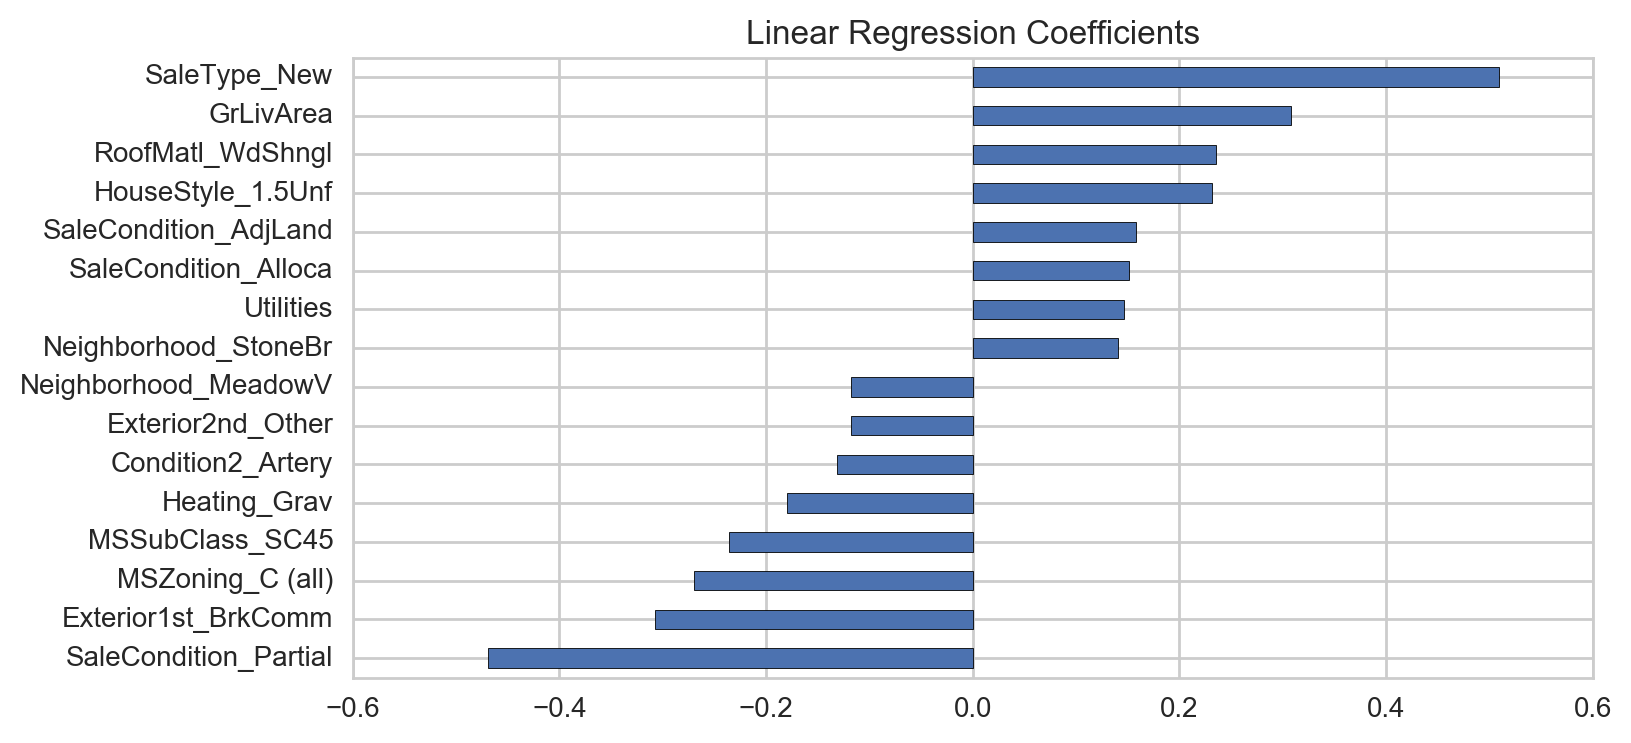

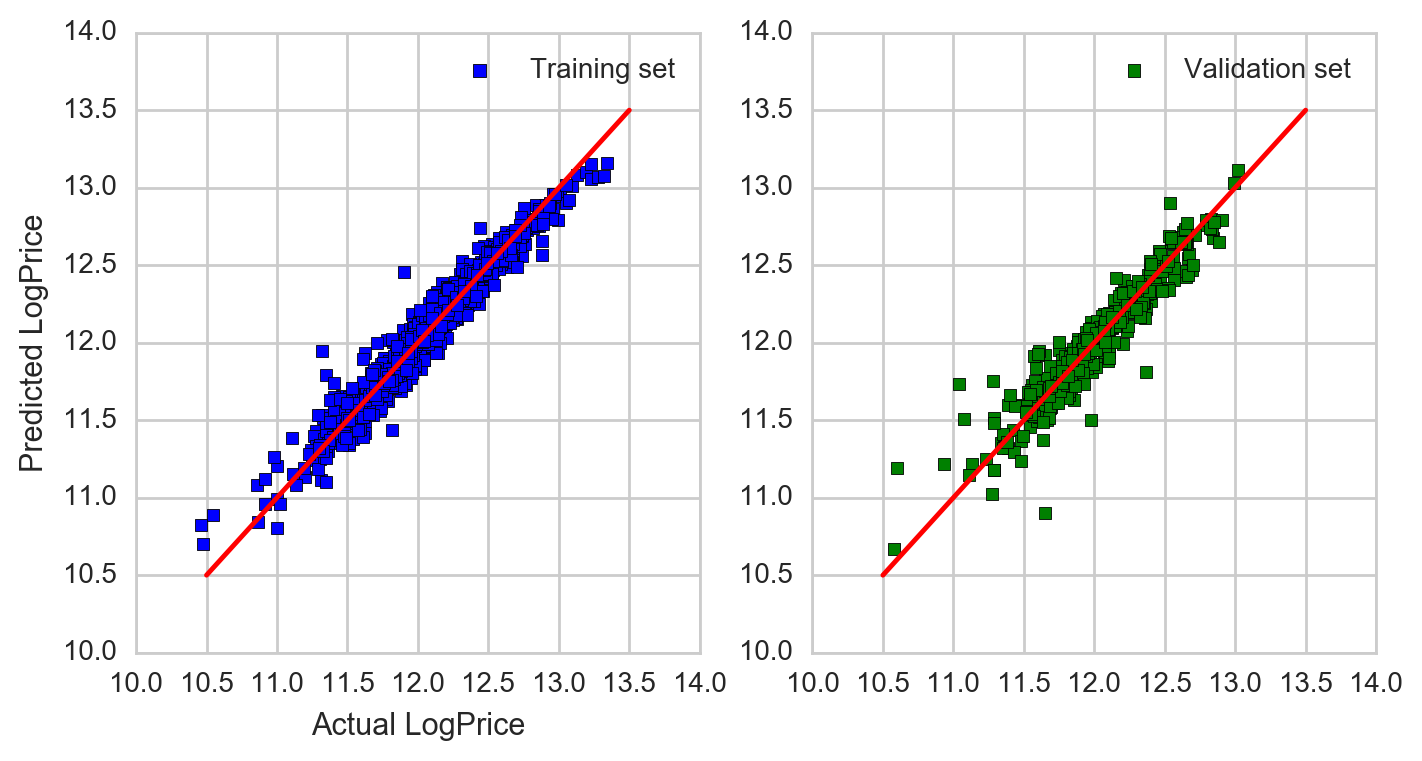

In [20]:
# selecting the best model
model_linear = LinearRegression().fit(X_train, y_train)
cv_linear = rmse_cv_train(model_linear).mean() 
print ("Training error:", cv_linear)
print ("Validation error:", rmse_cv_val(model_linear).mean())

# coefficients of linear regression
mp.rcParams['figure.figsize'] = (8, 4.0)

coeff_linear = pd.Series(model_linear.coef_, index = X_train.columns)
print("Intercept:", str(model_linear.intercept_))
print("No of features selected:", sum(coeff_linear!=0))
print("No of features eliminated:", sum(coeff_linear==0))

# view importance of coefficients sorted in ascending order
impt_coeff = pd.concat([coeff_linear.sort_values().head(8),
                        coeff_linear.sort_values().tail(8)]) 
impt_coeff.plot(kind = "barh")
plt.title("Linear Regression Coefficients")
plt.show()

# obtaining predictions
pred_train = model_linear.predict(X_train)
pred_val = model_linear.predict(X_val)

# graphing predicted vs actual
mp.rcParams['figure.figsize'] = (8, 4.0)
plt.subplot(121)
plt.scatter(y_train, pred_train, c = "blue", marker = "s", label = "Training set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.ylabel("Predicted LogPrice")
plt.xlabel("Actual LogPrice")
plt.legend()

plt.subplot(122)
plt.scatter(y_val, pred_val, c = "green", marker = "s", label = "Validation set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()



Most positive coefficient:  `SaleType_New` - Home just constructed and sold

Most negative coefficient: `SaleCondition_Partial` - Home was not completed when last assessed (associated with New Homes)

From the `counts` of the `SaleType_New` and `SaleCondition_Partial` below, it can be seen that `SaleCondition_Partial` is associated with New Homes. It is interesting to see that the former has a positive coefficient while the latter has a negative coefficient, when they  both are related to New Homes. This is because the coefficients must be interpreted as *isolated* effects of each variable on price - assuming other variables are constant. Without looking at `SaleType_New`, the uncompletion of the home (`SaleCondition_Partial`) negatively affects price.

Revised feature engineering (such as interaction effects between `SaleType_New` and `SaleCondition_Partial`) could be further explored in another python notebook file.




Counts: [120, 0, 3, 1333]
Means: 12.466118352611092 nan 11.963730861290168 11.982095339006426
Majority of the data are SaleType == New AND SaleCondition == Partial, or SaleType != New AND SaleCondition != Partial
showing that SaleCondition_New is associated with SaleCondition_Partial


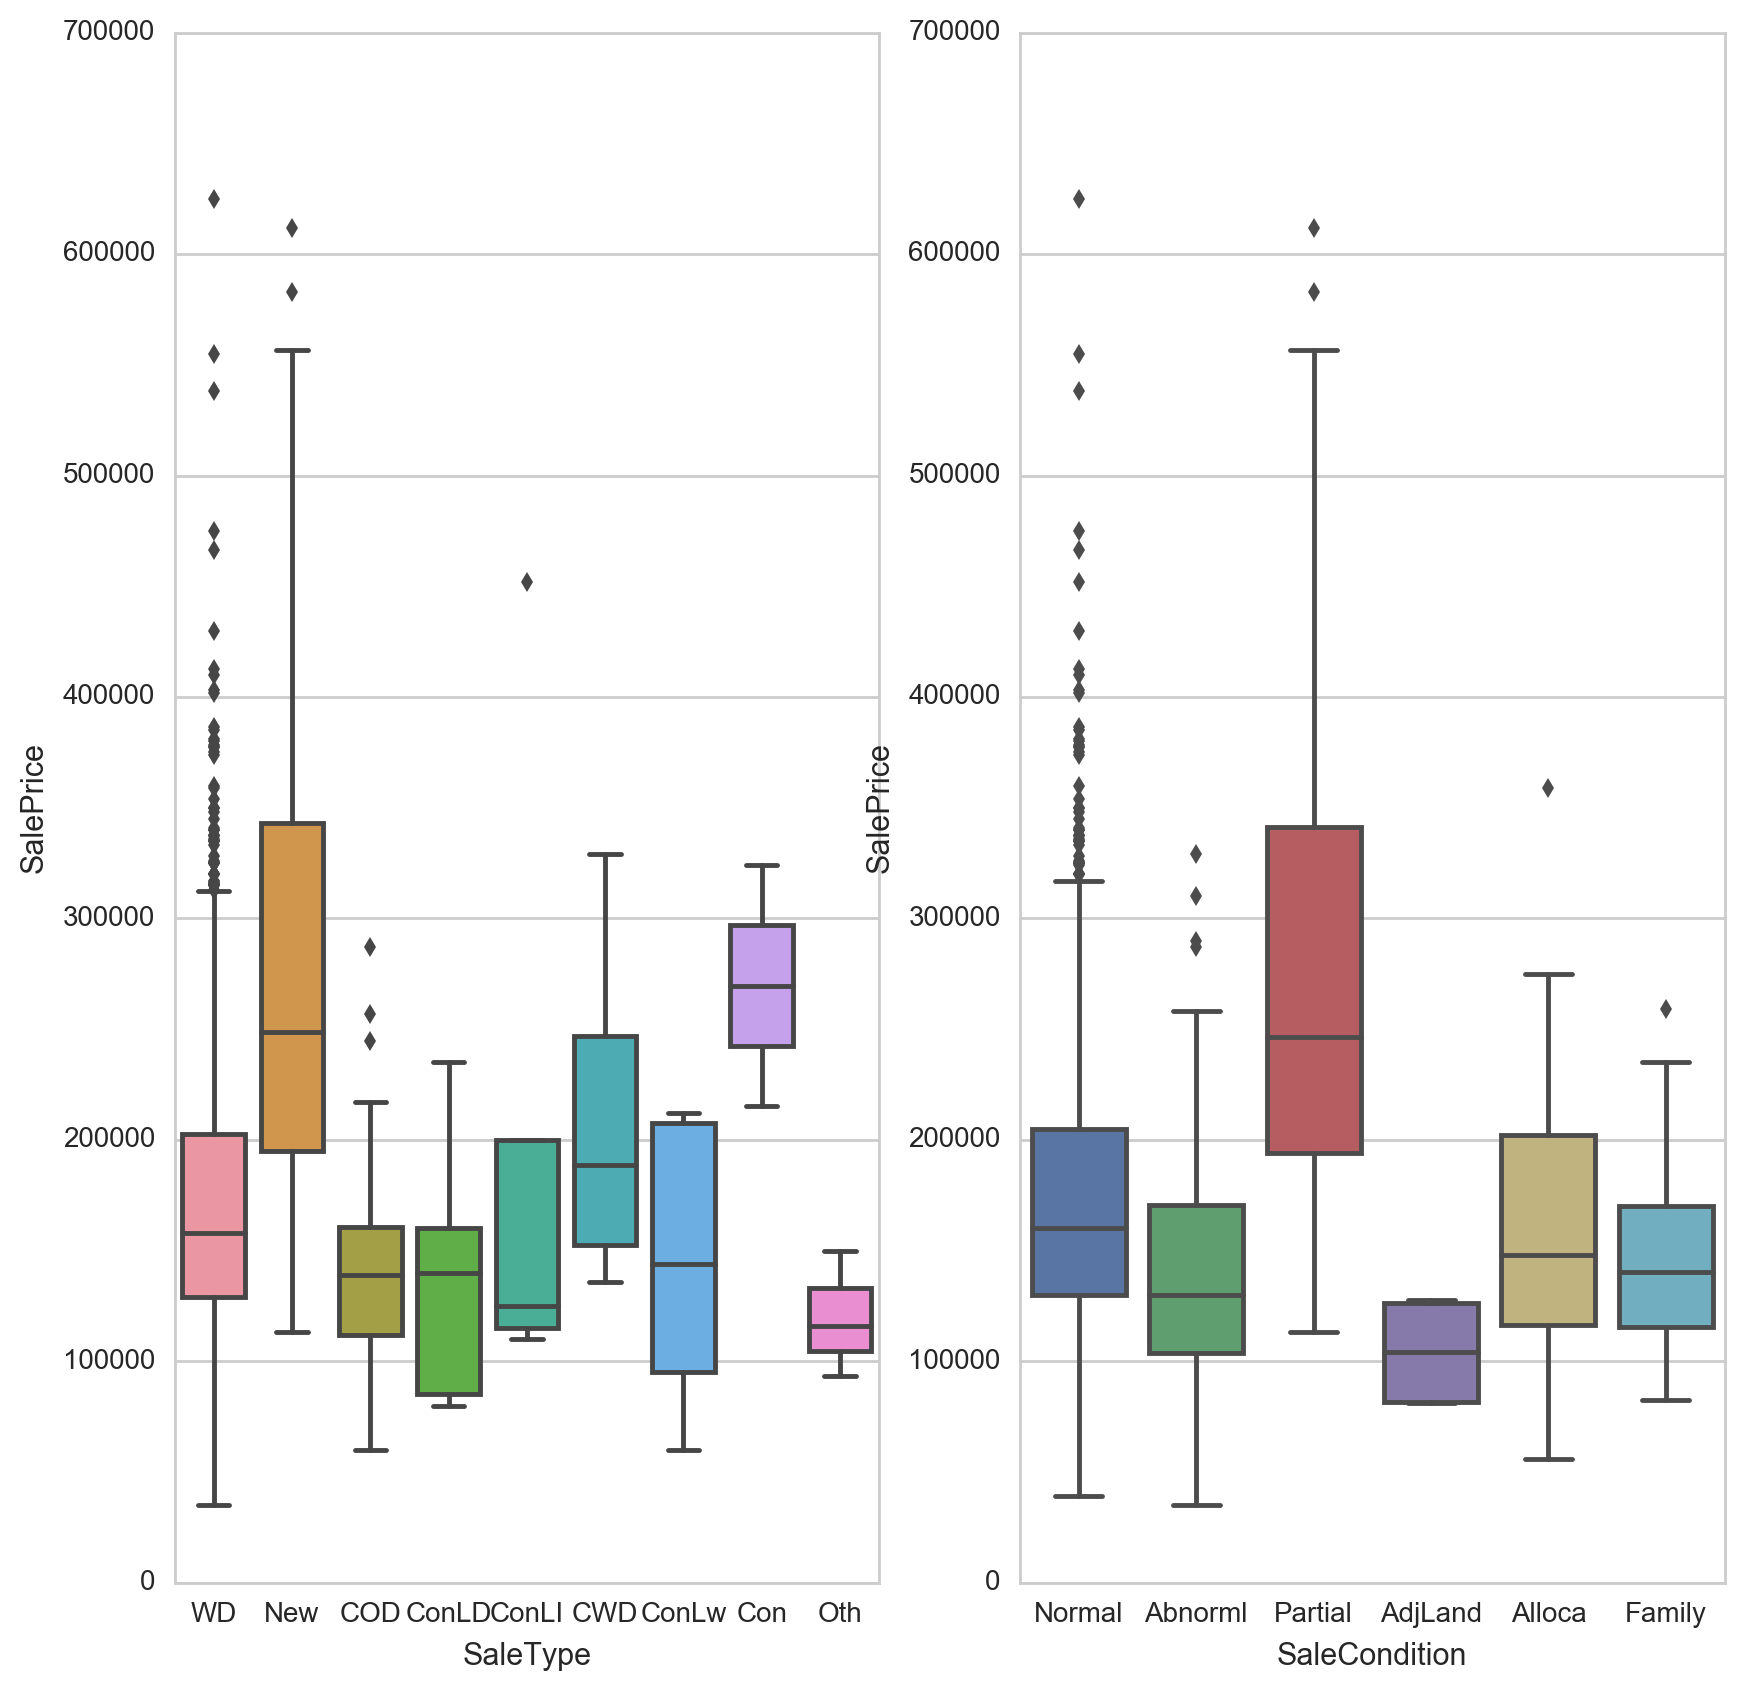

In [58]:
# different combinations of SaleType_New and SaleCondition_Partial
new_partial = train[(train.SaleType == 'New') & (train.SaleCondition == 'Partial')]
new_only = train[(train.SaleType == 'New') & (train.SaleCondition != 'Partial')]
partial_only = train[(train.SaleType != 'New') & (train.SaleCondition == 'Partial')]
notnew_notpartial = train[(train.SaleType != 'New')& (train.SaleCondition != 'Partial')]
counts = [new_partial.LogPrice.shape[0], new_only.LogPrice.shape[0],partial_only.LogPrice.shape[0], notnew_notpartial.LogPrice.shape[0]]

print ("Counts:",counts)
print ("Means:", new_partial.LogPrice.mean(), new_only.LogPrice.mean(), partial_only.LogPrice.mean(),
      notnew_notpartial.LogPrice.mean())
print ("Majority of the data are SaleType == New AND SaleCondition == Partial, or SaleType != New AND SaleCondition != Partial,")
print ("showing that SaleCondition_New is associated with SaleCondition_Partial.")


# box plots by SaleType and SaleCondition
mp.rcParams['figure.figsize'] = (10, 10.0)
plt.clf()
plt.subplot(121)
sb.boxplot(x=train.SaleType, y=train.SalePrice)
plt.subplot(122)
sb.boxplot(x=train.SaleCondition, y=train.SalePrice)


# Analysis of Residuals for Ordinary Least Squares

From below, residuals have mean 0, are uncorrelated and have equal variances. According to the Gauss-Markov Theorem, a linear regression model in which the residuals have expectation zero and are uncorrelated and have equal variances, the best linear unbiased estimator of the coefficients is given by the ordinary least squares (OLS) estimator. 


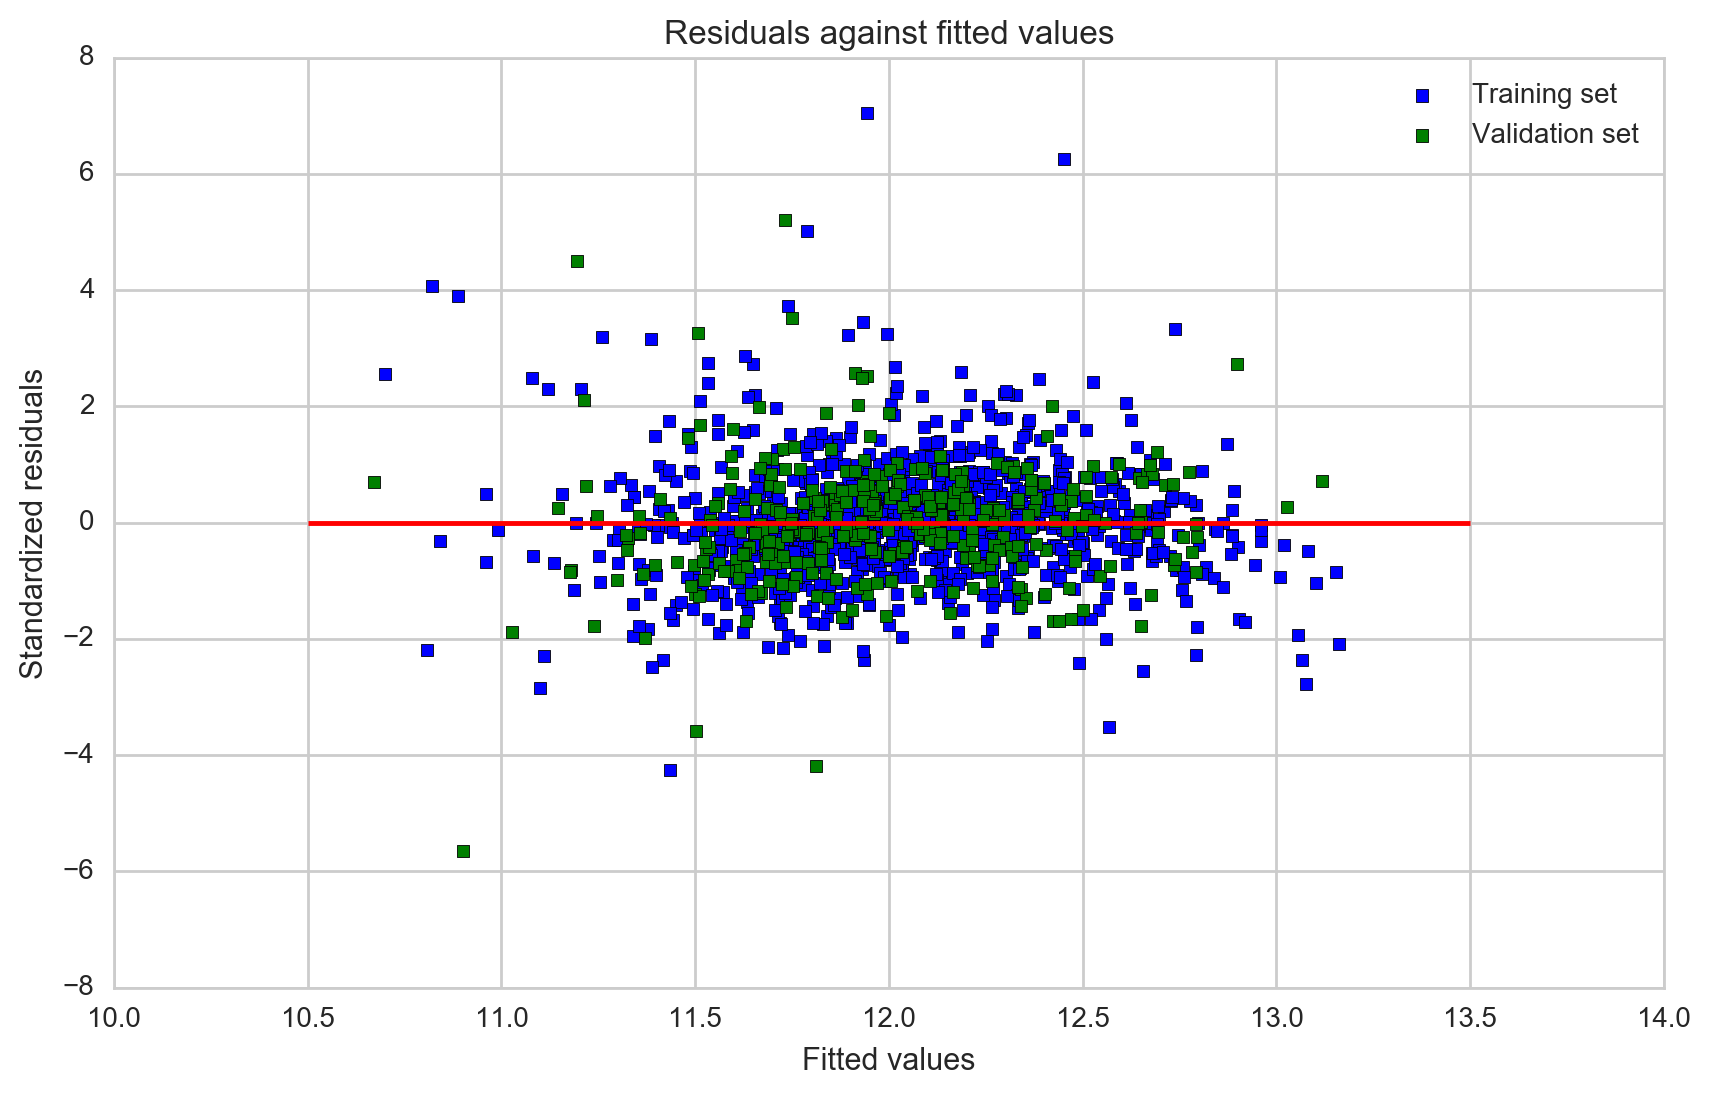

Mean of residuals_train: -1.1468237836787332e-15
Mean of residuals_val: -0.0003644703570252349
Var of residuals_train: 0.00786223426893029
Var of residuals_val: 0.017708620738020115


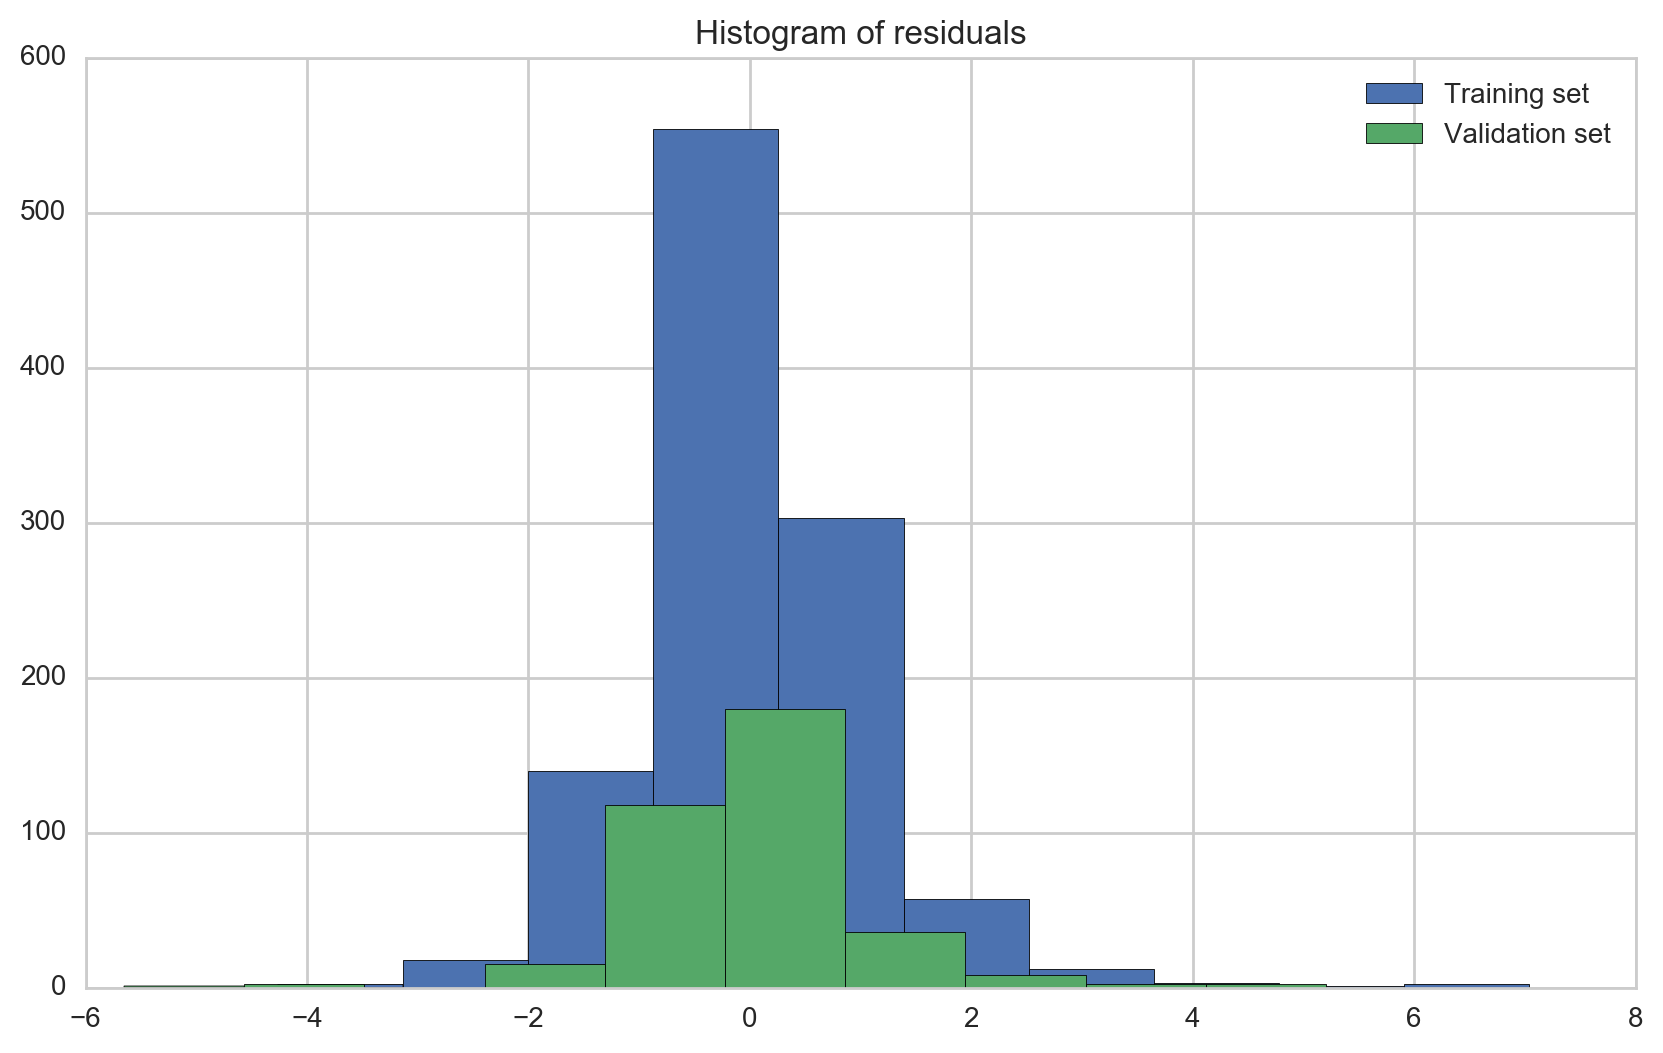

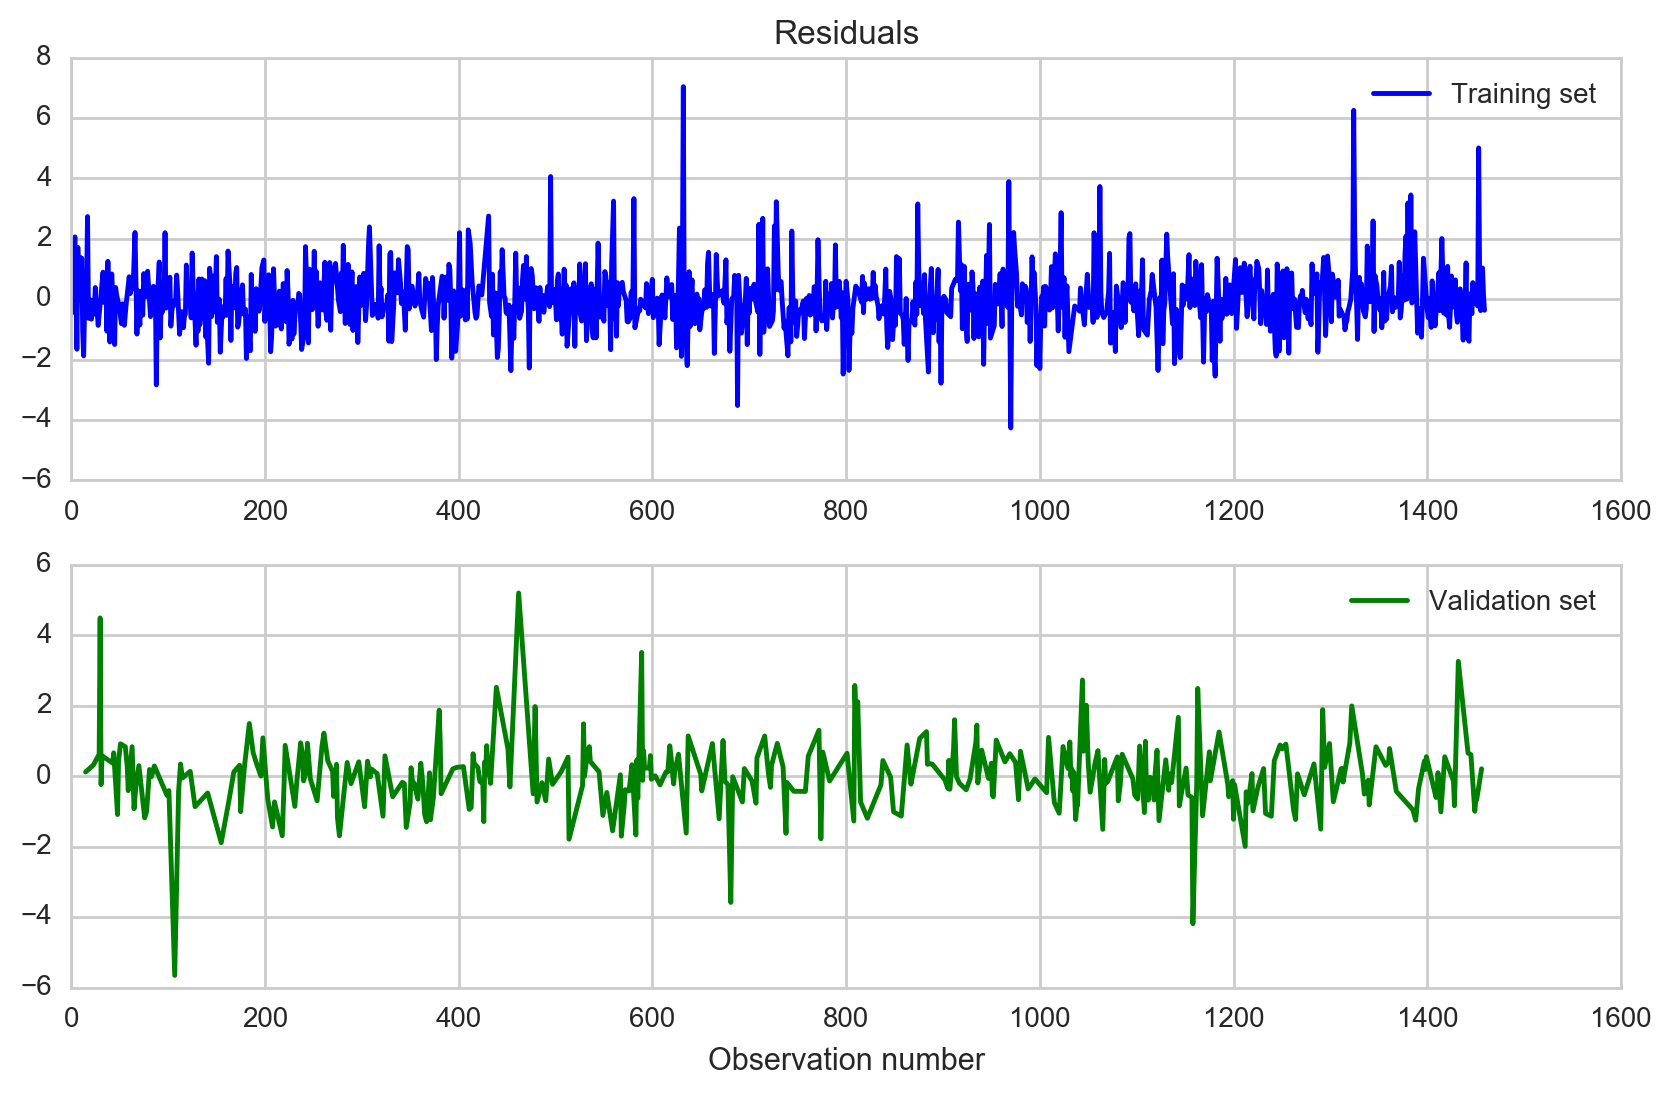

In [22]:
# calculate and standardize residuals
residuals_train = pred_train-y_train
residuals_val = pred_val - y_val
residuals_train = (residuals_train - residuals_train.mean()) / np.std(residuals_train)
residuals_val = (residuals_val - residuals_val.mean()) / np.std(residuals_val)

# check for equal variances
mp.rcParams['figure.figsize'] = (10.0, 6.0)
plt.scatter(pred_train, residuals_train, c = "blue", marker = "s", label = "Training set")
plt.scatter(pred_val, residuals_val, c = "green", marker = "s", label = "Validation set")
plt.title("Residuals against fitted values")
plt.xlabel("Fitted values")
plt.ylabel("Standardized residuals")
plt.legend()
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()


# check for mean and variance (unstandardized residuals)
print ("Mean of residuals_train: "+str((pred_train-y_train).mean()))
print ("Mean of residuals_val: "+str((pred_val - y_val).mean()))
print ("Var of residuals_train: "+str((pred_train-y_train).var()))
print ("Var of residuals_val: "+str((pred_val - y_val).var()))

plt.title("Histogram of residuals")
plt.hist(residuals_train, label = "Training set")
plt.hist(residuals_val, label="Validation set")
plt.legend()
plt.show()

# check if uncorrelated by order of observations
sorted_res_train = DataFrame.sort_index(residuals_train)
sorted_res_val = DataFrame.sort_index(residuals_val)
plt.subplot(211)
plt.title("Residuals")
plt.plot(sorted_res_train, c = "blue", label = "Training set")
plt.legend()
plt.subplot(212)
plt.plot(sorted_res_val, c = "green", label = "Validation set")
plt.xlabel("Observation number")
plt.legend()


Out of curiosity, what happens if we DID NOT log transform the y variable (SalePrice)? It appears that:
- Unequal variance of residuals (Fanning out effect). Variance gets larger for larger predicted values.
- Mean of residuals is very huge in the validation set (314.112)
- Variance of residuals in both training and validation sets are very large as compared to when LogSalePrice is used.

Therefore, using the SalePrice without transformation does NOT suit a linear model!


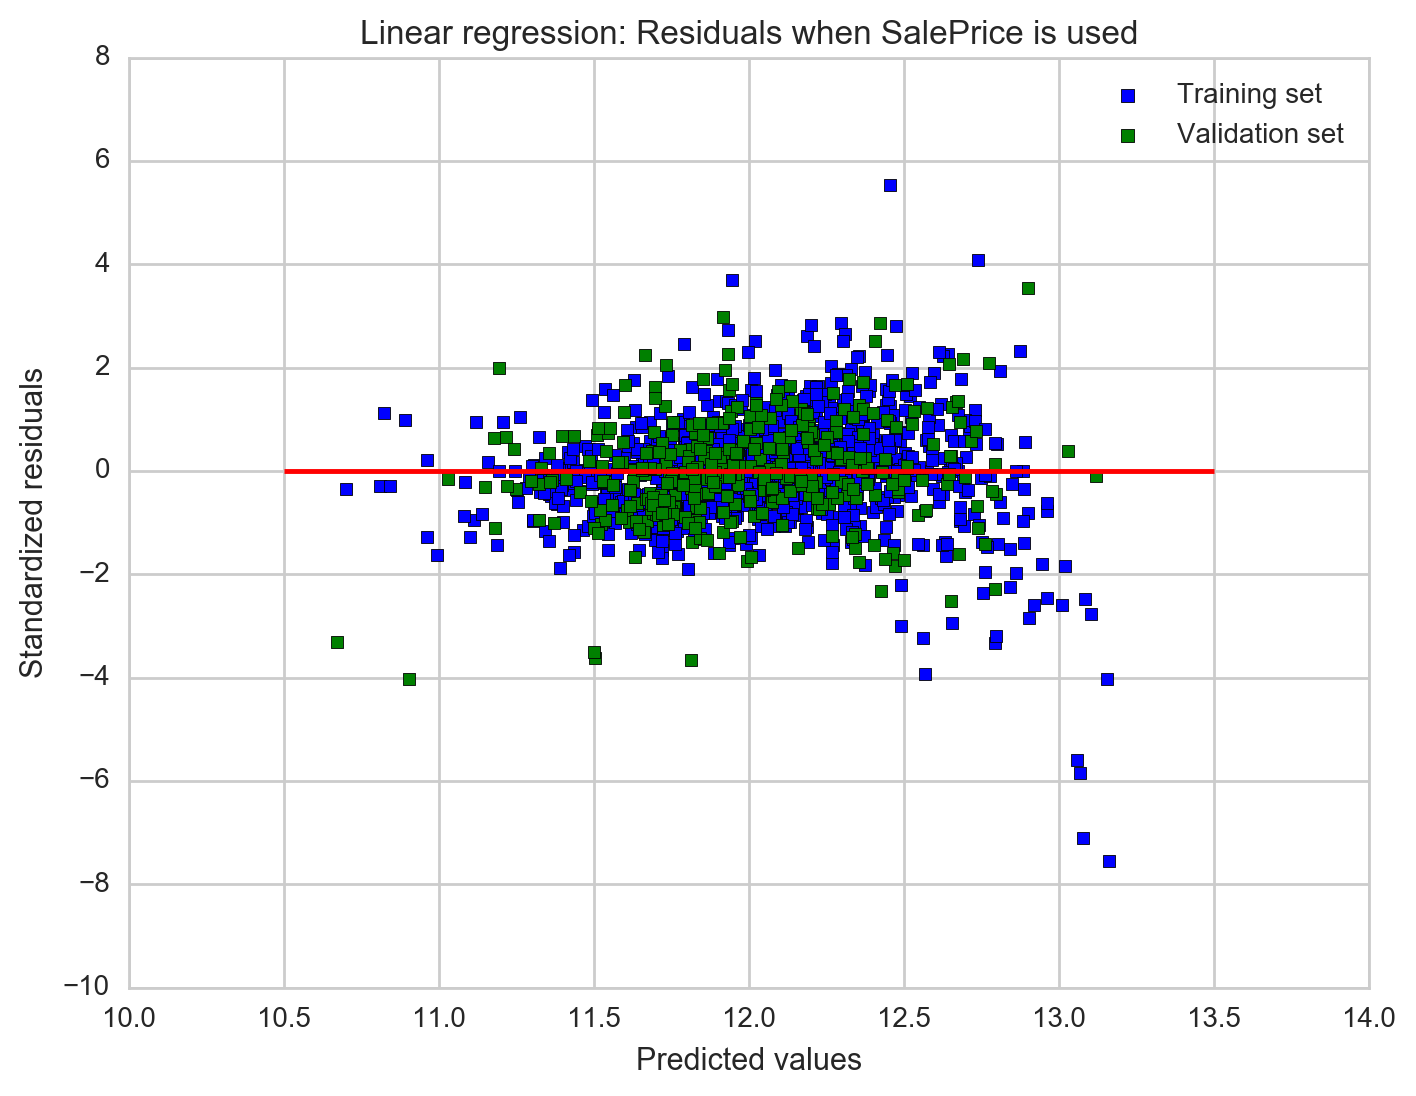

Mean of residuals_train: -5.977745543169233e-10
Mean of residuals_val: 314.11204186453733
Var of residuals_train: 502797899.6701874
Var of residuals_val: 779523551.2641705


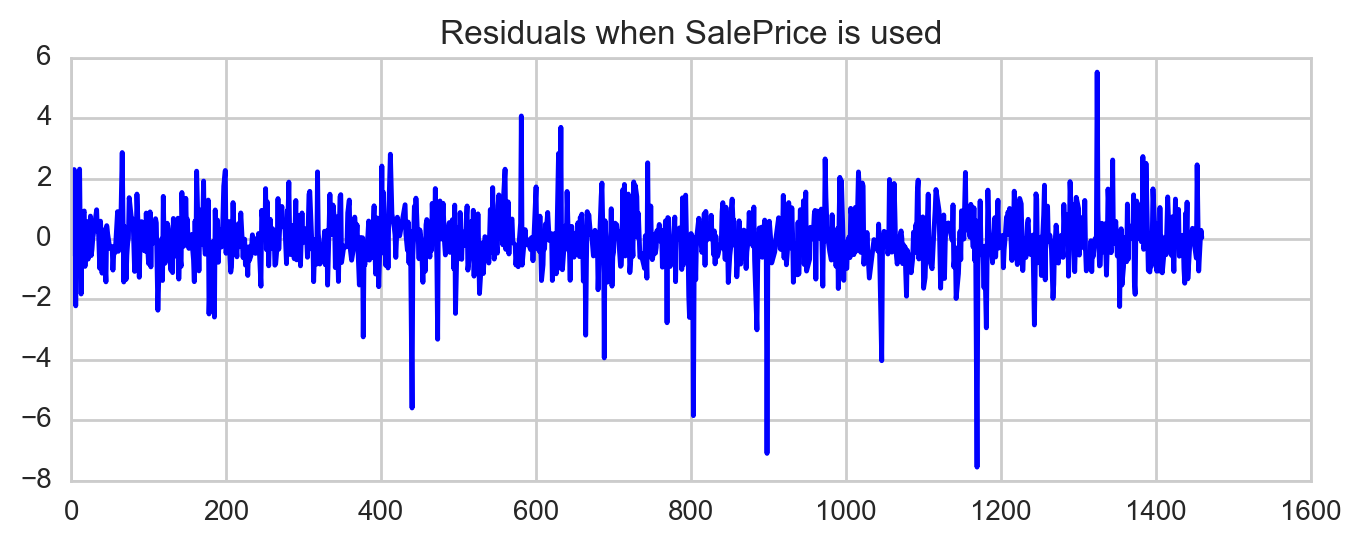

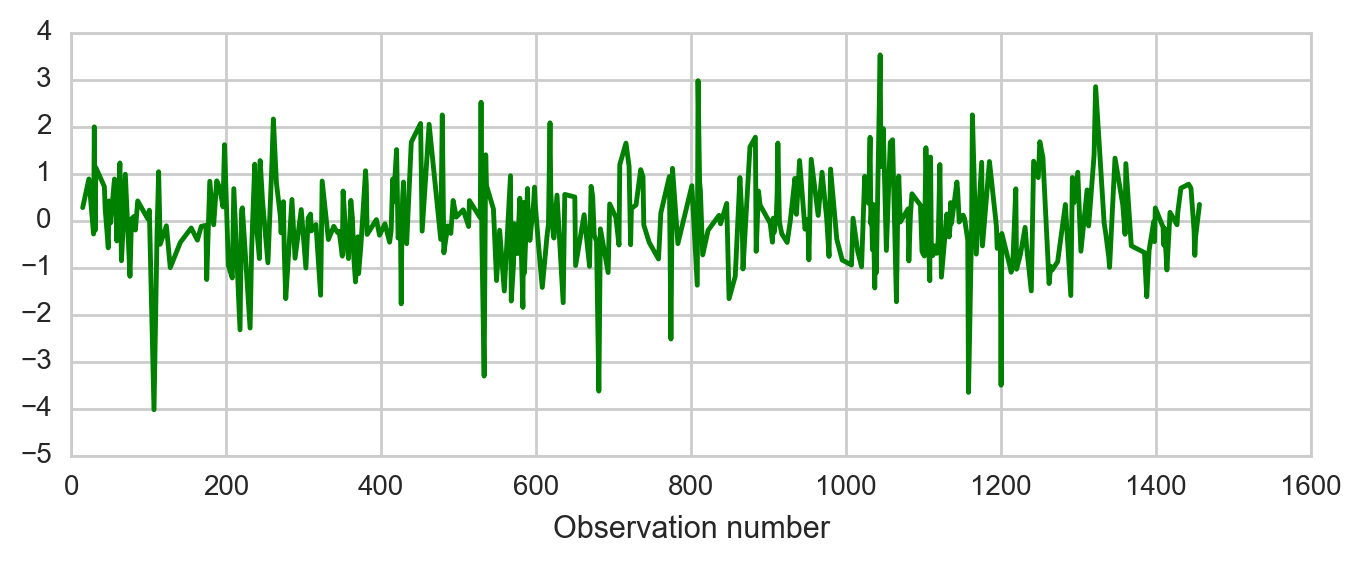

In [23]:
# convert logprice to price 
y_train2 = y_train
y_train2=np.exp(y_train2)
model_linear2 = LinearRegression().fit(X_train, y_train2)
y_val2 = y_val
y_val2=np.exp(y_val2)

# calculate and standardize residuals
pred_train2 = model_linear2.predict(X_train)
pred_val2 = model_linear2.predict(X_val)
residuals_train2 = pred_train2-y_train2
residuals_val2 = pred_val2-y_val2
residuals_train2 = (residuals_train2 - residuals_train2.mean()) / np.std(residuals_train2)
residuals_val2 = (residuals_val2 - residuals_val2.mean()) / np.std(residuals_val2)

# check for equal variances
mp.rcParams['figure.figsize'] = (8.0, 6.0)
plt.scatter(pred_train, residuals_train2, c = "blue", marker = "s", label="Training set")
plt.scatter(pred_val, residuals_val2, c = "green", marker = "s", label = "Validation set")
plt.title("Linear regression: Residuals when SalePrice is used")
plt.xlabel("Predicted values")
plt.ylabel("Standardized residuals")
plt.legend()
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# check mean and variance (unstandardized residuals)
print ("Mean of residuals_train: "+str((pred_train2-y_train2).mean()))
print ("Mean of residuals_val: "+str((pred_val2-y_val2).mean()))
print ("Var of residuals_train: "+str((pred_train2-y_train2).var()))
print ("Var of residuals_val: "+str((pred_val2-y_val2).var()))

# check if uncorrelated by order of observations
mp.rcParams['figure.figsize'] = (8.0, 6.0)
plt.subplot(211)
sorted_res_train2 = DataFrame.sort_index(residuals_train2)
plt.title("Residuals when SalePrice is used")
plt.plot(sorted_res_train2, c = "blue")
plt.show()
plt.subplot(212)
sorted_res_val2 = DataFrame.sort_index(residuals_val2)
plt.plot(sorted_res_val2, c = "green")
plt.xlabel("Observation number")
plt.show()


# Ridge Regression

Let's try to add some regularization to prevent overfitting and reduce the variance of our coefficients.

Training error: 0.116545230453
Validation error: 0.143474117035
Alpha: 10


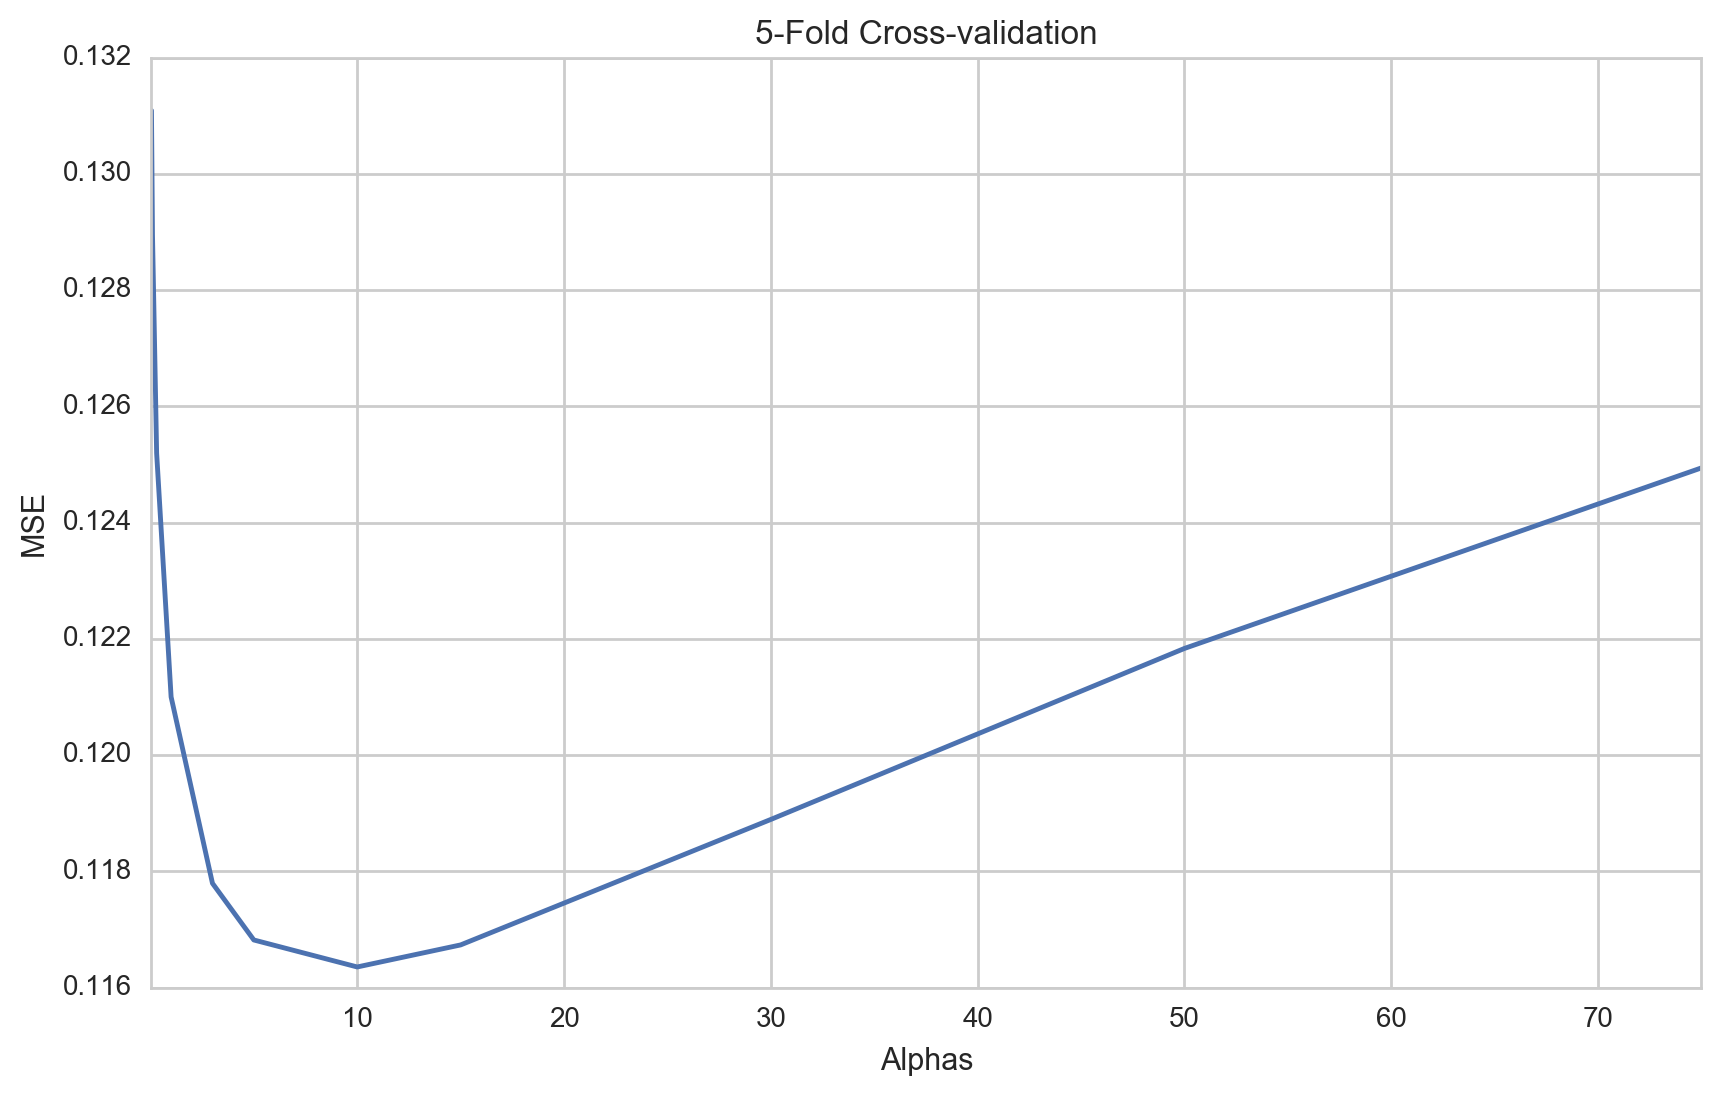

Intercept: 9.09171217394
No of features selected: 254
No of features eliminated: 5


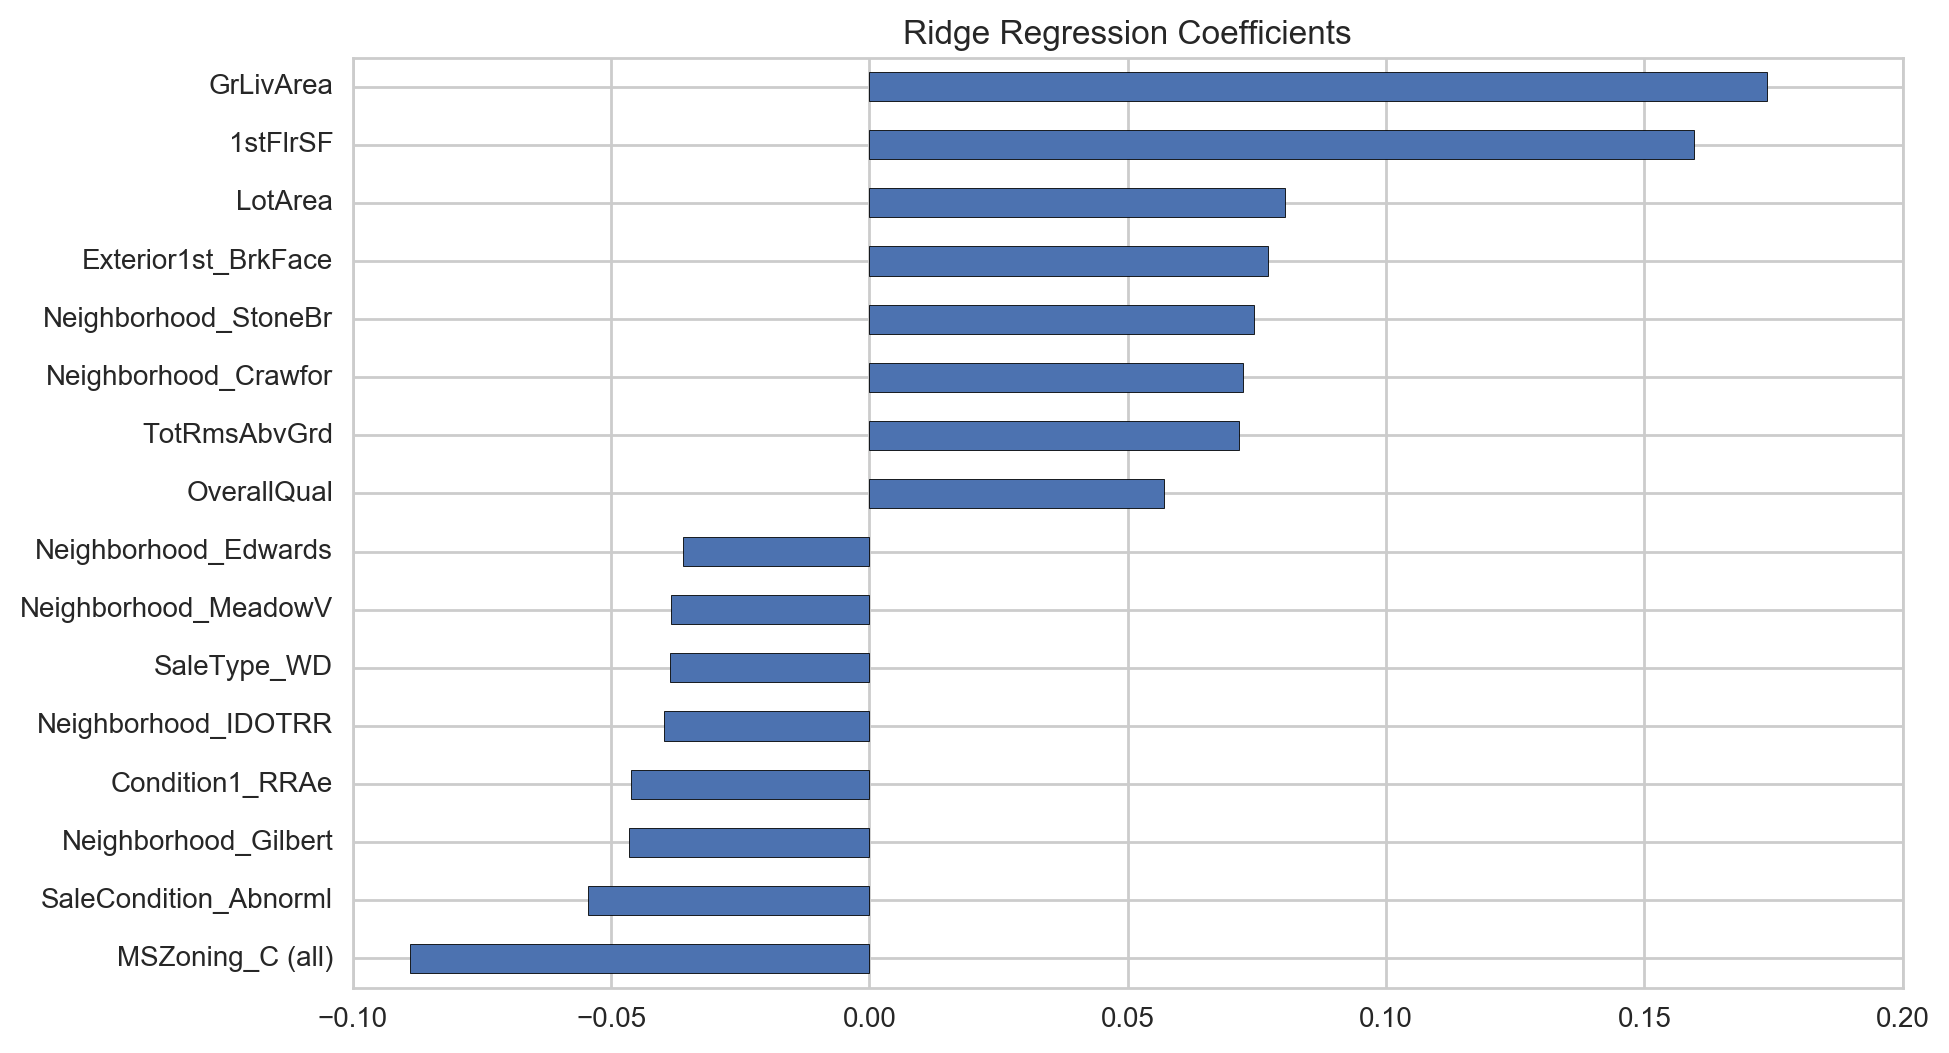

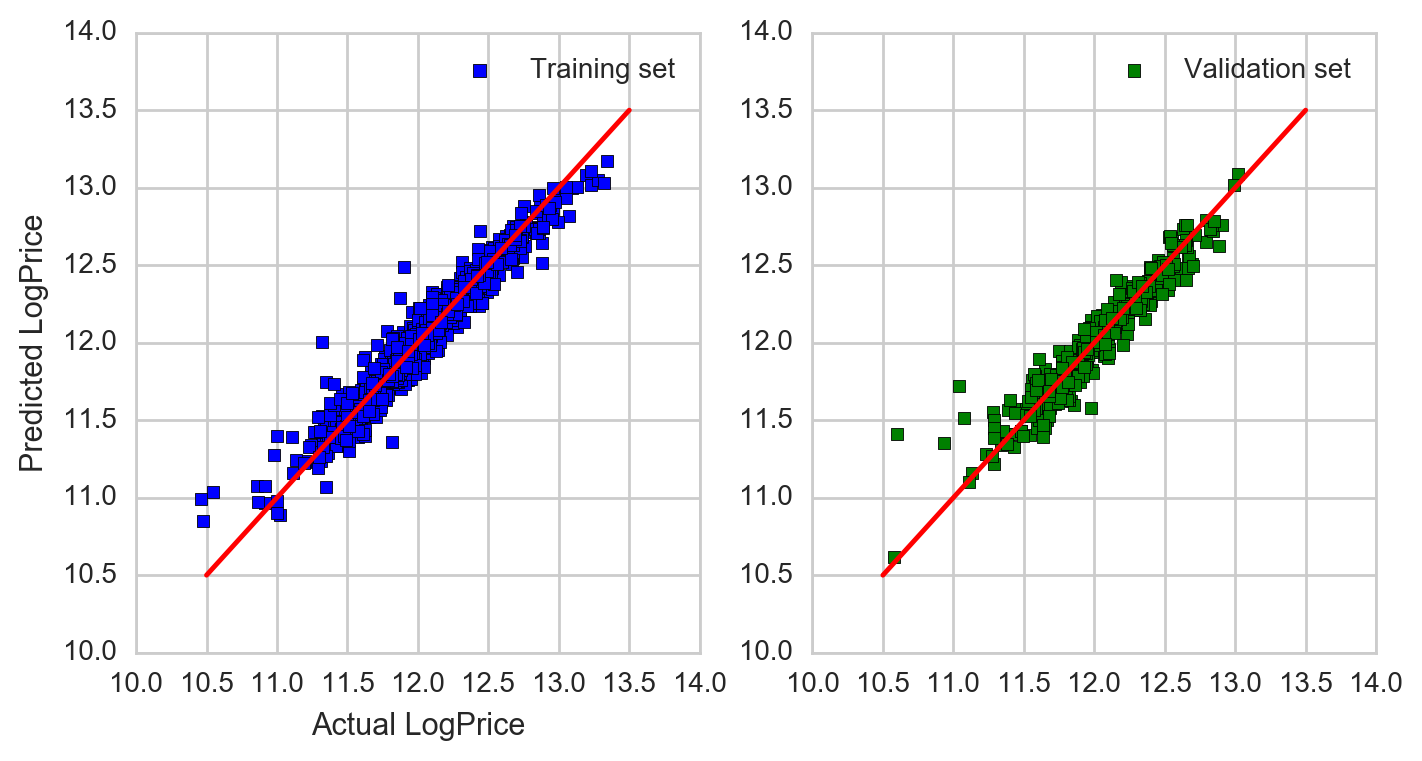

In [55]:
# select the best ridge regression model using RidgeCV
model_ridge = RidgeCV(alphas = [0.0005, 0.001, 0.1, 0.5, 1, 5, 10, 30], cv=5).fit(X_train, y_train)
cv_ridge = rmse_cv_train(model_ridge).mean() # average cv score for the optimal model, across the 5 folds
print ("Training error:", cv_ridge) 
print ("Validation error:", rmse_cv_val(model_ridge).mean())
print ("Alpha:", model_ridge.alpha_)

# plot CV errors for different alphas
regpars = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv_train(Ridge(alpha = regpar)).mean() 
            for regpar in regpars]
mp.rcParams['figure.figsize'] = (10.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = regpars)
cv_ridge.plot(title = "5-Fold Cross-validation")
plt.xlabel("Alphas")
plt.ylabel("MSE")
plt.show()

# coefficients of Ridge
coeff_ridge = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Intercept:", str(model_ridge.intercept_))
print("No of features selected:", sum(coeff_ridge!=0))
print("No of features eliminated:", sum(coeff_ridge==0))

# view importance of coefficients sorted in ascending order
impt_coeff = pd.concat([coeff_ridge.sort_values().head(8),
                        coeff_ridge.sort_values().tail(8)]) 
impt_coeff.plot(kind = "barh")
plt.title("Ridge Regression Coefficients")
plt.show()

# obtaining predictions
pred_train = model_ridge.predict(X_train)
pred_val = model_ridge.predict(X_val)

# graphing predicted vs actual
mp.rcParams['figure.figsize'] = (8, 4.0)
plt.subplot(121)
plt.scatter(y_train, pred_train, c = "blue", marker = "s", label = "Training set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.ylabel("Predicted LogPrice")
plt.xlabel("Actual LogPrice")
plt.legend()

plt.subplot(122)
plt.scatter(y_val, pred_val, c = "green", marker = "s", label = "Validation set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()


Both training and validation error are now lower than in the unregularized linear regression. As expected of L2 regularization which shrinks the coefficients, the coefficients (ranging from about -0.1 to 0.17) are smaller than the OLS case (ranging from about -0.5 to 0.5).

The most important positive feature is `GrLivArea` -  the above ground area by area square feet, followed by `1stFlrSF`, followed by `Lot Area`. Being located in neighborhood `Stone Brook` has a positive influence on sales price, as `Stone Brook` has the third highest median price among all neighborhoods.

The most important negative feature is `MSZoning_C`- being located in the Commercial Zone followed by `SaleCond_Abnorml` - an abnormal sale (eg trade, foreclosure, short sale).

The results seem logical. Refer to the boxplots in the Data Visualization section.



## Lasso CV

Let's try a sparse model for better interpretability.

In [25]:
# select the best LASSO model using cross-validation
model_lasso = LassoCV(alphas = [ 0.0005, 0.001, 0.1, 0.5, 1, 5, 10, 30], cv=5).fit(X_train, y_train)
cv_lasso = rmse_cv_train(model_lasso).mean() # mean of the 5 folds
print ("Training error:", cv_lasso)
print ("Validation error:", rmse_cv_val(model_lasso).mean())
print("Alpha: ", model_lasso.alpha_)


Training error: 0.114937538141
Validation error: 0.128921672135
Alpha:  0.0005


Intercept: 6.69970506749
No of features selected: 103
No of features eliminated: 156


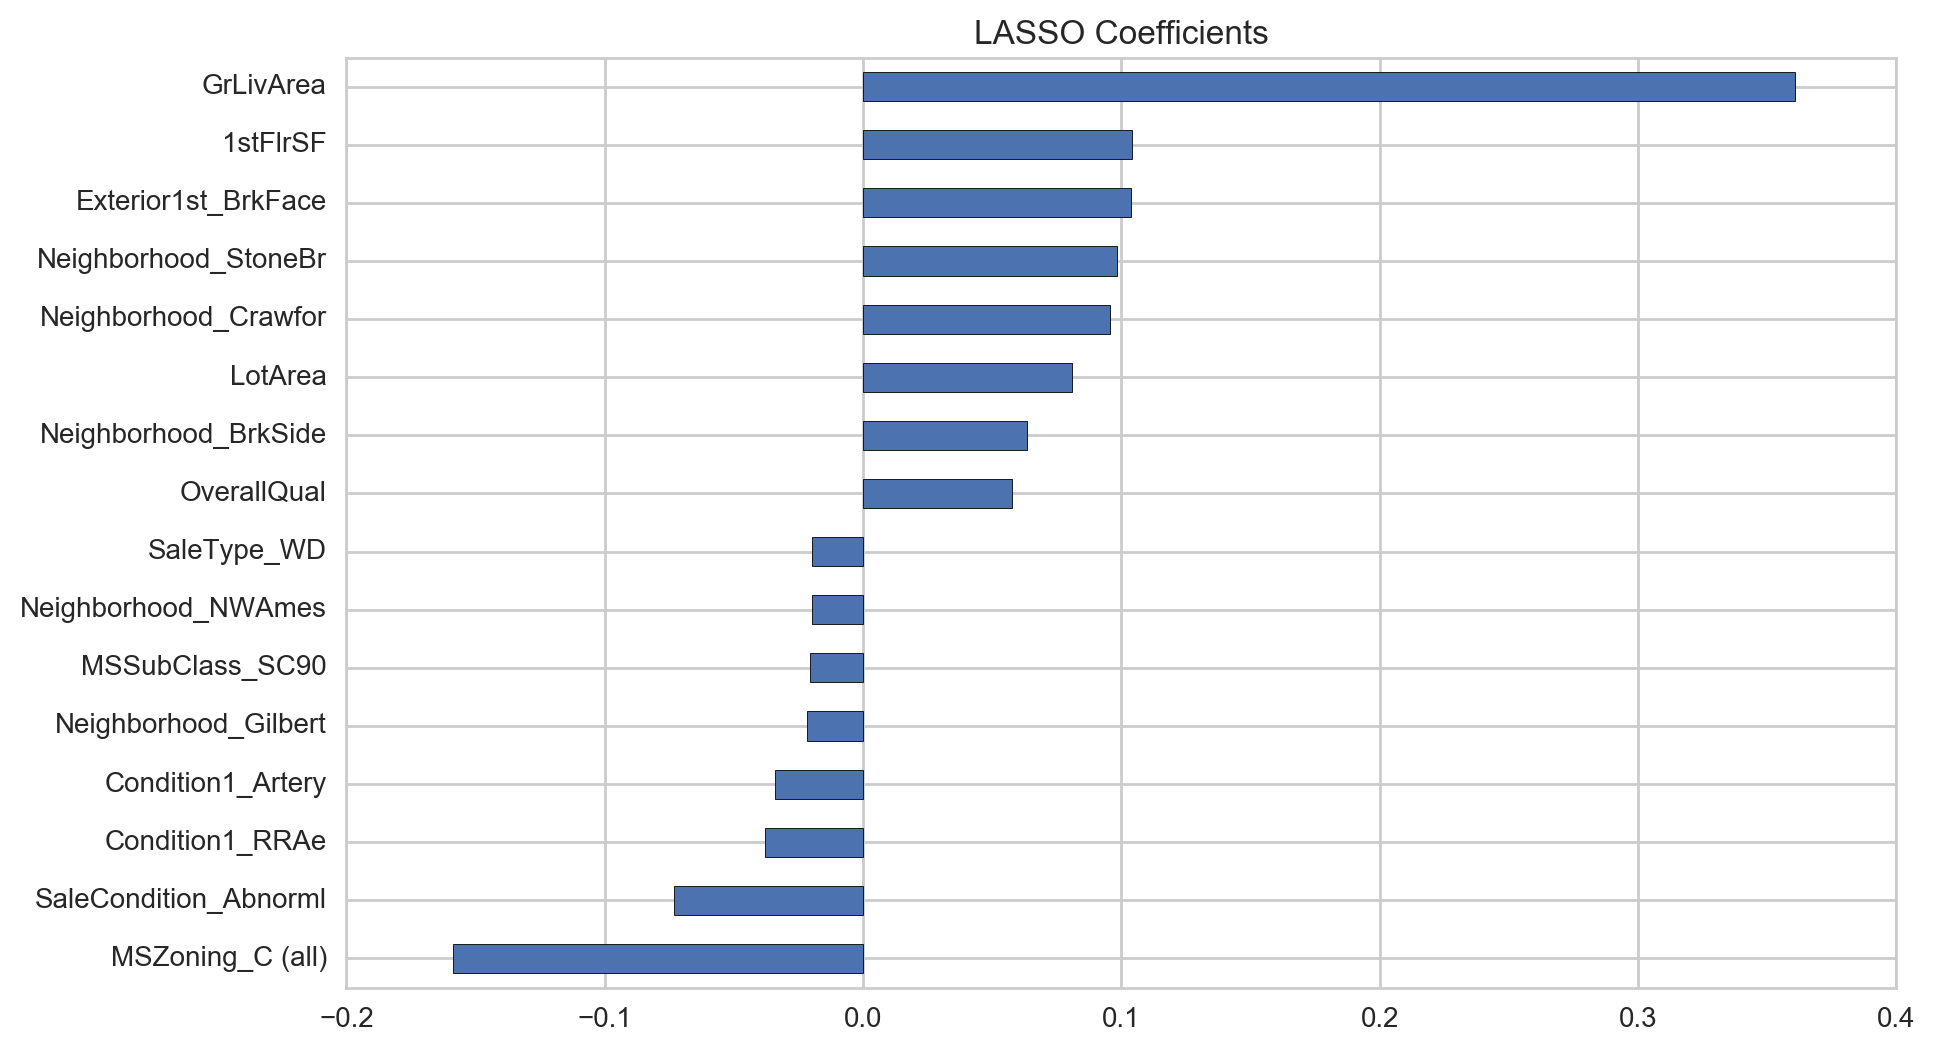

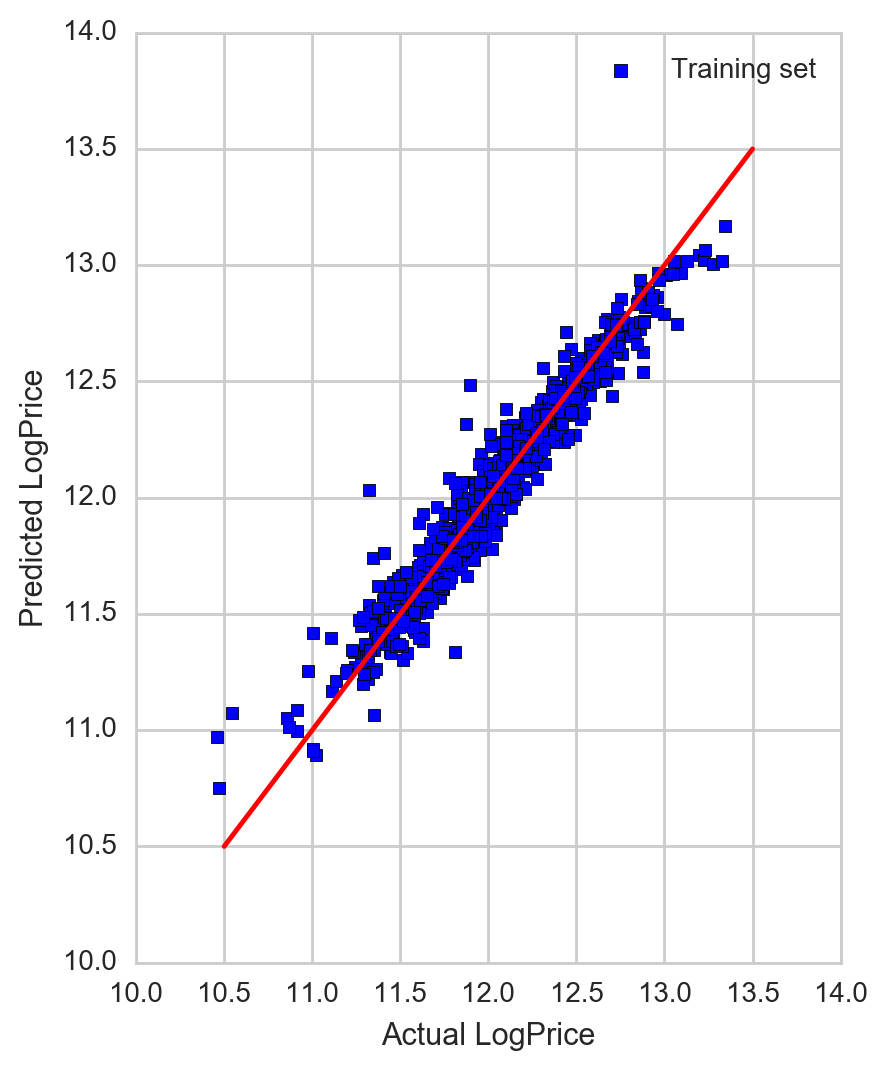

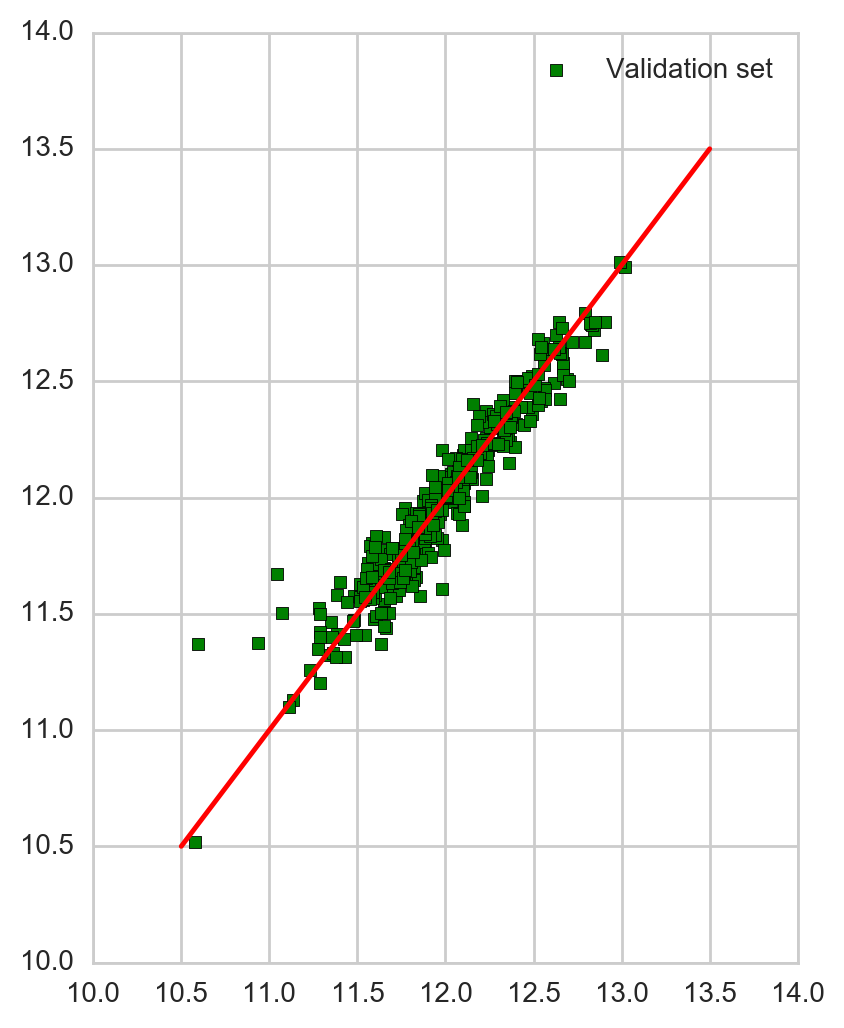

In [26]:
# coefficients of LASSO
coeff_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Intercept:", str(model_lasso.intercept_))
print("No of features selected:", sum(coeff_lasso!=0))
print("No of features eliminated:", sum(coeff_lasso==0))

# view importance of coefficients sorted in ascending order
# head shows most negative coefficients, tail shows most positive coefficients
impt_coeff = pd.concat([coeff_lasso.sort_values().head(8),
                        coeff_lasso.sort_values().tail(8)]) 
mp.rcParams['figure.figsize'] = (10.0, 6.0)
impt_coeff.plot(kind = "barh")
plt.title("LASSO Coefficients")
plt.show()

# obtaining predictions
pred_train = model_lasso.predict(X_train)
pred_val = model_lasso.predict(X_val)

# graphing predicted vs actual
mp.rcParams['figure.figsize'] = (10.0, 6.0)
plt.subplot(121)
plt.scatter(y_train, pred_train, c = "blue", marker = "s", label = "Training set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.ylabel("Predicted LogPrice")
plt.xlabel("Actual LogPrice")
plt.legend()
plt.show()

plt.subplot(122)
plt.scatter(y_val, pred_val, c = "green", marker = "s", label = "Validation set")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()

LASSO had a smaller training and test error than Ridge Regression, by using less coefficients than Ridge Regression. However, the number of coefficients used is still quite high at 103. The number of coefficients can be reduced to improve interpretability. 

The top two most important positive and negative coefficients are the same as in the Ridge Regression case. 

It may be hard to interpret the coefficients of the LASSO model because 

1)  We log-transformed the features

2) There is much multicollinearity, especially with the dummy variables

# Kaggle Submission

Comparing among ordinary least squares regression, ridge regression and LASSO, LASSO gave the lowest validation error. We shall use this to make predictions on the test set.

In [27]:
print ("LASSO has the lowest validation error.")
print ("Validation errors:")
print ("Ordinary least squares:",  rmse_cv_val(model_linear).mean())
print ("Ridge regression: ", rmse_cv_val(model_ridge).mean())
print ("LASSO:", rmse_cv_val(model_lasso).mean())



LASSO has the lowest validation error.
Validation errors:
Ordinary least squares: 0.209778773712
Ridge regression:  0.143474117035
LASSO: 0.128921672135


In [28]:
# predict on test set
pred_test = model_lasso.predict(X_test) 
pred_test=np.exp(pred_test) 

# write to file
cwd = os.getcwd()
path = os.path.join(cwd, 'Data')
submission = pd.read_csv(os.path.join(path, 'sample_submission.csv'))
submission['SalePrice'] = pred_test
print ("Dimensions of submission file:", submission.shape)
np.savetxt('submission1.csv', submission, delimiter=',')

Dimensions of submission file: (1459, 2)
